# Clasificación explicable de arritmias cardíacas a partir de electrocardiogramas transformados en espectrogramas mediante redes neuronales convolucionales

## Resumen
Este proyecto aborda la detección y clasificación de arritmias cardíacas a partir de señales de ECG crudas, transformadas en representaciones tiempo–frecuencia (espectrogramas), y analizadas con redes neuronales convolucionales (CNN). Se persigue un enfoque **explicable** que permita interpretar qué patrones del espectrograma sustentan las decisiones del modelo, aportando trazabilidad clínica y robustez metodológica.

## Objetivos
- **O1.** Construir un *pipeline* reproducible que convierta segmentos de ECG crudos en **espectrogramas**.
- **O2.** Entrenar y comparar tres arquitecturas CNN de referencia (**ResNet**, **MobileNet**, **EfficientNet**) para clasificación de arritmias.
- **O3.** Incorporar técnicas de **explicabilidad** (p. ej., Grad-CAM) para visualizar regiones relevantes en los espectrogramas.
- **O4.** Evaluar con métricas centradas en clases minoritarias (macro-F1, F1 por clase) y con **partición 70/15/15** estratificada y **agrupada por registro/paciente** para evitar *data leakage*.

## Contribución
1. **Pipeline extremo a extremo** desde ECG crudo → espectrograma → entrenamiento → explicabilidad.
2. **Evaluación justa** con división 70/15/15 sin fuga entre conjuntos (agrupación por `record_id`/paciente).
3. **Análisis comparativo** entre ResNet, MobileNet y EfficientNet con el mismo preprocesamiento.
4. **Explicabilidad** mediante mapas de activación sobre espectrogramas para interpretación clínica.

## Conjunto de datos
Se emplea **MIT-BIH Arrhythmia Database** (PhysioNet), accedido localmente desde `./mit-bih-arrhythmia-database-1.0.0`. El uso incluye:
- Lectura de señales y anotaciones (WFDB).
- Segmentación por latidos o ventanas deslizantes (p. ej., 2.5–5 s).
- Etiquetado según taxonomía AAMI u otra definida en el proyecto.
> Nota: se normalizarán frecuencias de muestreo y amplitudes para asegurar consistencia entre registros.

## Metodología (vista general)
1. **Preprocesamiento**: (opcional) filtrado banda 0.5–40 Hz y corrección de línea base; normalización por ventana.
2. **Representación**: cálculo de **espectrogramas** (p. ej., STFT/CWT), escala logarítmica y reescalado a tamaño estándar (p. ej., 224×224).
3. **Modelado**: *fine-tuning* de **ResNet**, **MobileNet** y **EfficientNet** (entrada 3 canales; el espectrograma en gris se replica a 3 canales).
4. **Entrenamiento**: **CrossEntropy** con **pesos por clase**, optimizador AdamW, *early stopping* por macro-F1.
5. **Evaluación**: accuracy, **macro-F1**, F1 por clase, matriz de confusión; reporte por clases AAMI.
6. **Explicabilidad**: Grad-CAM/Grad-CAM++ para visualizar regiones discriminativas del espectrograma.
7. **Reproducibilidad**: semillas fijadas, guardado de *splits*, pesos y *configs*.

## Partición de datos
Se aplicará una división **70%/15%/15%** con:
- **Estratificación por clase** (mantener proporciones).
- **Agrupación por `record_id`/paciente** (ningún registro se repite en train/val/test).

## Métricas y validación
- **Métrica principal**: **macro-F1** en validación/test.
- **Métricas secundarias**: F1 por clase, accuracy y matriz de confusión.
- (Opcional) Intervalos de confianza vía *bootstrap* para robustez estadística.

## Organización del notebook
1. **0. Configuración y utilidades**
2. **1. Carga de datos (WFDB) y segmentación**
3. **2. Preprocesamiento y generación de espectrogramas**
4. **3. Partición estratificada y agrupada (70/15/15)**
5. **4. Modelos (ResNet/MobileNet/EfficientNet)**
6. **5. Entrenamiento y *tuning***
7. **6. Evaluación y resultados**
8. **7. Explicabilidad (Grad-CAM)**
9. **8. Conclusiones y trabajo futuro**

---

> **Reproducibilidad**: Este notebook fija semillas aleatorias y guarda los índices de división, parámetros y pesos entrenados. Se recomienda versionar resultados (p. ej., `wandb/mlflow` o JSONs en disco).

In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.cuda.amp")

In [3]:
# ============================================================
# Multicore boost (ajustes globales de CPU/hilos)
# ============================================================
import os, multiprocessing, torch
import cv2

num_cores = multiprocessing.cpu_count()
print(f" Núcleos detectados: {num_cores}")

# PyTorch CPU threading: intra-op y inter-op
# (debe llamarse lo antes posible)
torch.set_num_threads(num_cores)          # cómputo interno en CPU
torch.set_num_interop_threads(num_cores)  # paralelismo entre operadores
print(f" PyTorch threads -> intra:{torch.get_num_threads()} inter:{torch.get_num_interop_threads()}")

# Variables de entorno para runtimes nativos (OpenMP/MKL/NumExpr)
os.environ["OMP_NUM_THREADS"] = str(num_cores)
os.environ["MKL_NUM_THREADS"] = str(num_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(num_cores)

# OpenCV puede lanzar sus propios hilos; alineamos para evitar sobre-suscripción
try:
    cv2.setNumThreads(max(1, num_cores - 1))
except Exception:
    pass

# CUDNN: auto-tuning (si usas GPU y tamaño de entrada fijo)
torch.backends.cudnn.benchmark = True

 Núcleos detectados: 12
 PyTorch threads -> intra:12 inter:12


In [4]:
import torch
print("Versión de PyTorch:", torch.__version__)
print("Versión de CUDA:", torch.version.cuda)
print("cuDNN:", torch.backends.cudnn.version())
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))


Versión de PyTorch: 2.9.0+cu128
Versión de CUDA: 12.8
cuDNN: 91002
CUDA disponible: True
GPU detectada: NVIDIA GeForce GTX 1660 Ti


# Sección 1 — Carga de datos (WFDB)

In [5]:
# ============================================================
# 1. Utilidades WFDB + AAMI + build_df_beats (MITDB + SVDB)
# ============================================================

from pathlib import Path
import glob, wfdb
import numpy as np
import pandas as pd
from typing import List, Iterable, Optional, Set, Tuple
from scipy.signal import resample_poly

# ------------------------------------------------------------
# Configuración de rutas y parámetros base
# ------------------------------------------------------------
DATA_DIR_MITDB = "./mit-bih-arrhythmia-database-1.0.0"
DATA_DIR_SVDB  = "./mit-bih-supraventricular-arrhythmia-database-1.0.0"
FS_TARGET = 360
SVDB_ALLOWED_CLASSES = {"S", "V", "F", "Q"}

assert Path(DATA_DIR_MITDB).exists(), f"No se encontró MITDB en {DATA_DIR_MITDB}"
assert Path(DATA_DIR_SVDB).exists(), f"No se encontró SVDB en {DATA_DIR_SVDB}"

# ------------------------------------------------------------
# 1) Descubrir registros
# ------------------------------------------------------------
def list_records(data_dir: str) -> List[str]:
    """Devuelve los IDs de registro de una base MIT-BIH o SVDB."""
    d = Path(data_dir)
    records_file = d / "RECORDS"
    if records_file.is_file():
        recs = [ln.strip() for ln in records_file.read_text().splitlines() if ln.strip()]
        if not recs:
            raise ValueError(f"Archivo RECORDS vacío en {data_dir}")
        return recs
    heas = {Path(p).stem for p in glob.glob(str(d / "*.hea"))}
    dats = {Path(p).stem for p in glob.glob(str(d / "*.dat"))}
    recs = sorted(heas & dats)
    if not recs:
        raise FileNotFoundError(f"No se encontraron registros válidos en {data_dir}")
    return recs

# ------------------------------------------------------------
# 2) Mapeo MIT-BIH → AAMI
# ------------------------------------------------------------
AAMI_MAP = {
    "N":"N","L":"N","R":"N","e":"N","j":"N",
    "A":"S","a":"S","J":"S","S":"S",
    "V":"V","E":"V",
    "F":"F",
    "f":"Q","/":"Q","Q":"Q","?":"Q","~":"Q","|":"Q","x":"Q","B":"Q","p":"Q","t":"Q"
}
AAMI_VALID: Set[str] = {"N","S","V","F","Q"}

def mitbih_symbol_to_aami(sym: str) -> str:
    return AAMI_MAP.get(sym, "Q")

# ------------------------------------------------------------
# 3) Lectura segura + remuestreo opcional
# ------------------------------------------------------------
def load_record(record_id: str, data_dir: str, fs_target: int = 360) -> Tuple[np.ndarray, int, np.ndarray, np.ndarray]:
    """Lee señal y anotaciones; remuestrea si es necesario."""
    rec_path = str(Path(data_dir) / record_id)
    try:
        rec = wfdb.rdrecord(rec_path)
        sig = np.asarray(rec.p_signal, dtype=np.float32)
        fs_src = int(rec.fs)
    except Exception:
        sigs, flds = wfdb.rdsamp(rec_path)
        sig = np.asarray(sigs, dtype=np.float32)
        fs_src = int(flds.get("fs") or flds.get("fsamp") or flds["fs"])
    try:
        ann = wfdb.rdann(rec_path, "atr")
        ann_samples = ann.sample.astype(np.int64)
        ann_symbols = np.asarray(ann.symbol)
    except Exception:
        ann_samples = np.empty(0, dtype=np.int64)
        ann_symbols = np.empty(0, dtype=str)
    if sig.ndim == 1:
        sig = sig[:, None]
    if fs_src != fs_target and ann_samples.size > 0:
        from math import gcd
        up, down = fs_target, fs_src
        g = gcd(up, down)
        up //= g; down //= g
        sig = resample_poly(sig, up, down, axis=0).astype(np.float32)
        ann_samples = np.round(ann_samples * (fs_target / fs_src)).astype(np.int64)
        fs_src = fs_target
    return sig, fs_src, ann_samples, ann_symbols

# ------------------------------------------------------------
# 4) Construcción del DataFrame de latidos
# ------------------------------------------------------------
def build_df_beats(records: Iterable[str],
                   data_dir: str,
                   db_name: str,
                   use_channel: int = 0,
                   fs_target: int = 360,
                   keep_aami: Optional[Set[str]] = None) -> pd.DataFrame:
    keep = AAMI_VALID if keep_aami is None else set(keep_aami)
    rows = []
    to_aami = np.frompyfunc(lambda s: AAMI_MAP.get(s, "Q"), 1, 1)
    for rid in records:
        try:
            sig, fs, ann_idx, ann_sym = load_record(rid, data_dir, fs_target)
        except Exception as e:
            print(f"[Error] {db_name}/{rid}: {e}")
            continue
        if ann_idx.size == 0:
            continue
        if use_channel >= sig.shape[1]:
            print(f"[Aviso] Canal {use_channel} no existe en {rid}. Se omite.")
            continue
        aami_arr = to_aami(ann_sym).astype(str)
        mask = np.isin(aami_arr, list(keep))
        if not np.any(mask):
            continue
        sel_idx = ann_idx[mask].astype(int)
        sel_sym = ann_sym[mask].astype(str)
        sel_aam = aami_arr[mask].astype(str)
        n_samples = sig.shape[0]
        for si, sy, am in zip(sel_idx, sel_sym, sel_aam):
            rows.append({
                "record_id": rid,
                "db": db_name,
                "fs": fs,
                "sample_index": int(si),
                "symbol": sy,
                "aami": am,
                "n_samples_record": n_samples,
                "channel": use_channel,
                "source": data_dir,
                "patient_id": rid.split("-")[0] if "-" in rid else rid
            })
    df = pd.DataFrame(rows)
    if df.empty:
        print(f"[Aviso] No se generaron latidos para {db_name}")
        return df
    return df.sort_values(["db", "record_id", "sample_index"]).reset_index(drop=True)

# ------------------------------------------------------------
# 5) Construcción y filtrado de ambos datasets
# ------------------------------------------------------------
mitdb_records = list_records(DATA_DIR_MITDB)
svdb_records  = list_records(DATA_DIR_SVDB)
print(f"MITDB: {len(mitdb_records)} registros | SVDB: {len(svdb_records)} registros")

# 5.1 — Construir SVDB sin filtrar (incluyendo N) para evaluar % no-N
df_svd_full = build_df_beats(svdb_records, DATA_DIR_SVDB, "SVDB", fs_target=FS_TARGET, keep_aami=None)

# 5.2 — Filtrar por ≥10% de no-N usando el df completo
valid_svdb = []
for rec, g in df_svd_full.groupby("record_id"):
    frac_nonN = (g["aami"] != "N").mean()
    if frac_nonN >= 0.10:
        valid_svdb.append(rec)
print(f"Registros SVDB válidos tras filtro no-N>=10%: {len(valid_svdb)}")

# 5.3 — Aplicar el filtro de clases permitidas (S,V,F,Q) SOLO después
df_svd = df_svd_full[df_svd_full["record_id"].isin(valid_svdb)]
df_svd = df_svd[df_svd["aami"].isin(SVDB_ALLOWED_CLASSES)]

# 5.4 — Construir MITDB normal
df_mit = build_df_beats(mitdb_records, DATA_DIR_MITDB, "MITDB", fs_target=FS_TARGET)

# 5.5 — Combinar y resumir
df_beats = pd.concat([df_mit, df_svd], ignore_index=True)
print(f"Latidos totales combinados: {len(df_beats):,}")
print("\nDistribución inicial por clase AAMI:")
print(df_beats["aami"].value_counts())

df_beats.to_csv("df_beats_mitdb_svdb.csv", index=False)
print("\n[OK] DataFrame combinado guardado en df_beats_mitdb_svdb.csv")


# ------------------------------------------------------------
# 6) Combinación y resumen
# ------------------------------------------------------------
df_beats = pd.concat([df_mit, df_svd], ignore_index=True)
print(f"Latidos totales combinados: {len(df_beats):,}")
print("\nDistribución inicial por clase AAMI:")
print(df_beats["aami"].value_counts())

# Guardar CSV combinado
df_beats.to_csv("df_beats_mitdb_svdb.csv", index=False)
print("\n[OK] DataFrame combinado guardado en df_beats_mitdb_svdb.csv")

MITDB: 48 registros | SVDB: 78 registros
Registros SVDB válidos tras filtro no-N>=10%: 31
Latidos totales combinados: 133,320

Distribución inicial por clase AAMI:
aami
N    90631
V    15439
Q    13988
S    12459
F      803
Name: count, dtype: int64

[OK] DataFrame combinado guardado en df_beats_mitdb_svdb.csv
Latidos totales combinados: 133,320

Distribución inicial por clase AAMI:
aami
N    90631
V    15439
Q    13988
S    12459
F      803
Name: count, dtype: int64

[OK] DataFrame combinado guardado en df_beats_mitdb_svdb.csv


### Ventanas centradas en R-peak → df_windows

* Define **`WindowCfg`**: parámetros del ventaneo (duración en segundos, normalización z-score por ventana y modo de padding).
* **`_slice_with_padding`**: extrae un segmento `x[start:end]` y, si se sale del rango, **rellena** con `np.pad` (p. ej., `reflect`) para no perder latidos en los bordes.
* **`extract_windows`**: para cada latido en `df_beats`, carga la señal del registro, toma el **canal** indicado y construye una **ventana de longitud fija** alrededor del **R-peak** (índice anotado).

  * Asegura que todas las ventanas tengan exactamente `win_sec * fs` muestras.
  * Aplica **z-score por ventana** si corresponde.
  * Devuelve `df_windows` con columnas: `record_id, fs, start_idx, end_idx, center_idx, signal (np.ndarray), label (AAMI), symbol`.
* Al final imprime una muestra (`head`), el **número de ventanas**, la **distribución AAMI** y la **longitud** (en muestras) de cada ventana.


In [6]:
# ============================================================
# 2. Extracción de ventanas ECG (MITDB + SVDB)
# ============================================================
from dataclasses import dataclass
from typing import Optional
import numpy as np
import pandas as pd

@dataclass
class WindowCfg:
    win_sec: float = 2.5
    center: str = "rpeak"            # futuro: soportar otros centros
    zscore_per_window: bool = True
    pad_mode: str = "reflect"        # 'reflect' | 'edge' | 'constant'

def _slice_with_padding(x: np.ndarray, start: int, length: int, pad_mode: str = "reflect") -> np.ndarray:
    """
    Extrae una ventana de longitud fija `length` empezando en `start`.
    Si se sale de los límites, aplica padding y garantiza retorno de tamaño exacto.
    """
    n = x.shape[0]
    end = start + length
    xs, xe = max(start, 0), min(end, n)
    core = x[xs:xe]

    left_pad = max(0, -start)
    right_pad = max(0, end - n)
    if left_pad or right_pad:
        core = np.pad(core, (left_pad, right_pad), mode=pad_mode)

    if core.shape[0] != length:  # corrección extra de seguridad
        if core.shape[0] > length:
            core = core[:length]
        else:
            core = np.pad(core, (0, length - core.shape[0]), mode=pad_mode)
    return core

def extract_windows(df_beats: pd.DataFrame,
                    cfg: Optional[WindowCfg] = None,
                    use_channel: int = 0) -> pd.DataFrame:
    """
    Devuelve df_windows con columnas:
    record_id, fs, start_idx, end_idx, center_idx, signal (np.ndarray 1D), label (AAMI), symbol
    """
    if cfg is None:
        cfg = WindowCfg()

    out_rows = []
    eps = 1e-6

    # Agrupar por base de datos y registro
    for (db_name, rid), g in df_beats.groupby(["db", "record_id"], sort=False):
        if db_name.upper() == "MITDB":
            data_dir = DATA_DIR_MITDB
        elif db_name.upper() == "SVDB":
            data_dir = DATA_DIR_SVDB
        else:
            print(f"[Aviso] Base desconocida: {db_name}, se omite {rid}")
            continue

        sig, fs, _, _ = load_record(rid, data_dir)
        sig1 = sig[:, use_channel].astype(np.float32, copy=False)

        win_len = int(round(cfg.win_sec * fs))
        half = win_len // 2

        for _, row in g.iterrows():
            center_idx = int(row["sample_index"])
            start = center_idx - half
            xw = _slice_with_padding(sig1, start, win_len, pad_mode=cfg.pad_mode)

            if cfg.zscore_per_window:
                mu = float(np.mean(xw))
                sd = float(np.std(xw)) + eps
                xw = (xw - mu) / sd

            out_rows.append({
                "db": db_name,
                "record_id": rid,
                "fs": fs,
                "start_idx": max(start, 0),
                "end_idx": min(start + win_len, sig1.shape[0]),
                "center_idx": center_idx,
                "signal": xw,
                "label": row["aami"],
                "symbol": row["symbol"],
            })

    dfw = pd.DataFrame(out_rows)
    return dfw.sort_values(["db", "record_id", "start_idx", "center_idx"]).reset_index(drop=True) if not dfw.empty else dfw


# ------------------------------------------------------------
# Uso
# ------------------------------------------------------------
cfg = WindowCfg(win_sec=2.5, zscore_per_window=True, pad_mode="reflect")
df_windows = extract_windows(df_beats, cfg=cfg, use_channel=0)

print(df_windows.head(3))
print("Ventanas construidas:", len(df_windows))
print("Distribución AAMI en ventanas:", df_windows['label'].value_counts().to_dict() if not df_windows.empty else {})
print("Longitud de señal por ventana (muestras):",
      int(df_windows.iloc[0]['signal'].shape[0]) if not df_windows.empty else None)


      db record_id   fs  start_idx  end_idx  center_idx  \
0  MITDB       100  360          0      468          18   
1  MITDB       100  360          0      527          77   
2  MITDB       100  360          0      820         370   

                                              signal label symbol  
0  [-0.5875537, -0.63959813, -0.6656203, -0.53550...     Q      +  
1  [4.0415654, 5.432875, 6.220409, 6.404167, 6.06...     N      N  
2  [2.435993, 4.267938, 5.5503, 5.94286, 5.628812...     N      N  
Ventanas construidas: 133320
Distribución AAMI en ventanas: {np.str_('N'): 90631, np.str_('V'): 15439, np.str_('Q'): 13988, np.str_('S'): 12459, np.str_('F'): 803}
Longitud de señal por ventana (muestras): 900


In [7]:
# ============================================================
# 3. Verificación de consistencia de ventanas (sanity check)
# ============================================================
"""
* Frecuencias por record: verifica que cada record_id tenga la misma fs dentro de sus ventanas
  y cuenta cuántos registros hay por cada fs.
* NaNs en ventanas: revisa si alguna ventana (signal) contiene valores NaN y cuenta cuántas ventanas afectadas hay.
* Longitud constante: comprueba que todas las ventanas tienen la misma longitud (en muestras).
* Cobertura por clase: sanity check de desbalance: muestra el mínimo número de ventanas entre las clases AAMI.
"""

import numpy as np

# 1) Frecuencia por record → distribución de fs
fs_dist = (
    df_windows.groupby(["db", "record_id"])["fs"].first()
    .value_counts()
    .to_dict()
)
print("Frecuencias por record:", fs_dist)

# 2) NaNs en las ventanas
n_nans = int(df_windows["signal"].apply(lambda x: np.isnan(x).any()).sum())
print("Ventanas con valores NaN:", n_nans)

# 3) Longitud de cada ventana (debe ser constante)
lens = df_windows["signal"].apply(lambda x: x.shape[0]).value_counts().to_dict()
print("Longitudes de ventana (conteos):", lens)

# 4) Mínimo por clase (sanity check)
if not df_windows.empty:
    class_counts = df_windows["label"].value_counts().to_dict()
    min_per_class = int(min(class_counts.values()))
    print("Conteo por clase:", class_counts)
    print("Mínimo por clase (sanity):", min_per_class)
else:
    print("df_windows vacío; no se puede calcular cobertura por clase.")

Frecuencias por record: {360: 79}
Ventanas con valores NaN: 0
Longitudes de ventana (conteos): {900: 133320}
Conteo por clase: {np.str_('N'): 90631, np.str_('V'): 15439, np.str_('Q'): 13988, np.str_('S'): 12459, np.str_('F'): 803}
Mínimo por clase (sanity): 803


# Seccion 2 Preprocesamiento y generación de espectrogramas

### Config de espectrograma (STFT) y utilidades

* **SpecCfg**: define hiperparámetros del espectrograma:
    * **STFT**: 
        * `nperseg=128`, 
        * `noverlap=64`, 
        * `window='hann'`, 
        * `nfft` (opcional).
    * **Posprocesado**: 
        * Recorta frecuencias por encima de `fmax=60 Hz`, 
        * Aplica `log1p`, 
        * Normaliza, 
        * Redimensiona a `224×224`.
    * **Normalización**: 
        * `zscore_then_minmax` (z-score por imagen y luego min–max) 
        * o solo `minmax`, con recorte de outliers por percentiles.

* **_normalize_img**: Recorta intensidades por percentiles para limitar outliers y normaliza según el modo elegido (evita divisiones por cero con `eps`).
* **_safe_nfft**: Garantiza un `nfft` válido (al menos `nperseg`; si dan uno menor, ajusta a la siguiente potencia de 2 ≥ `nperseg`).
* **signal_to_spec_img**: Pipeline completo:
    1. STFT y módulo |Z|;
    2. Filtra filas de frecuencia `f <= fmax`;
    3. `log1p` para comprimir rango dinámico;
    4. Normaliza y convierte a `uint8`;
    5. Redimensiona a `224×224` con OpenCV.

In [8]:
# ============================================================
# 4. Espectrograma STFT y utilidades (versión 1-canal)
# ============================================================
import numpy as np
import cv2
from dataclasses import dataclass
from scipy.signal import stft

@dataclass
class SpecCfg:
    # Parámetros de la STFT
    nperseg: int = 128
    noverlap: int = 64
    nfft: int | None = None              # si None ⇒ usa nperseg
    window: str = "hann"

    # Post-procesado
    fmax: float | None = 60.0            # Hz; None para no recortar
    eps: float = 1e-6
    out_size: int = 224                  # salida cuadrada (px)

    # Normalización
    normalize: str = "zscore_then_minmax"    # "zscore_then_minmax" | "minmax"
    clip_percentiles: tuple[float, float] = (1.0, 99.0)

def _normalize_img(
    img: np.ndarray,
    eps: float,
    mode: str,
    clip_percentiles=(0.0, 100.0)
) -> np.ndarray:
    """Normaliza la magnitud del espectrograma para obtener una imagen [0,1]."""
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    lo, hi = clip_percentiles
    if (lo, hi) != (0.0, 100.0):
        finite = np.isfinite(img)
        if finite.any():
            vlo, vhi = np.percentile(img[finite], [lo, hi])
            if vhi > vlo:
                img = np.clip(img, vlo, vhi)

    if mode == "zscore_then_minmax":
        std = img.std()
        img = (img - img.mean()) / (std + eps)
        img = img - img.min()
        img = img / (img.max() + eps)
    elif mode == "minmax":
        img = img - img.min()
        img = img / (img.max() + eps)
    else:
        raise ValueError("normalize debe ser 'zscore_then_minmax' o 'minmax'")
    return img

def _safe_nfft(nperseg: int, nfft: int | None) -> int:
    """Asegura que nfft sea al menos nperseg y potencia de 2."""
    if nfft is None:
        return nperseg
    if nfft < nperseg:
        return int(2 ** int(np.ceil(np.log2(nperseg))))
    return int(nfft)

def signal_to_spec_img(sig_1d: np.ndarray, fs: float, cfg: SpecCfg) -> np.ndarray:
    """Convierte una señal 1D normalizada en un espectrograma 1-canal (uint8)."""
    sig_1d = np.asarray(sig_1d, dtype=np.float32)
    if not np.isfinite(sig_1d).all():
        sig_1d = np.nan_to_num(sig_1d, nan=0.0, posinf=0.0, neginf=0.0)

    nfft_eff = _safe_nfft(cfg.nperseg, cfg.nfft)
    nover = int(min(cfg.noverlap, cfg.nperseg - 1))

    # --- STFT ---
    f, t, Z = stft(
        sig_1d,
        fs=fs,
        window=cfg.window,
        nperseg=cfg.nperseg,
        noverlap=nover,
        nfft=nfft_eff,
        padded=False,
        boundary=None
    )

    mag = np.abs(Z)
    mag = np.nan_to_num(mag, nan=0.0, posinf=0.0, neginf=0.0)

    # --- Recorte de banda ---
    if cfg.fmax is not None and f.size > 0:
        mask = (f <= cfg.fmax)
        if not np.any(mask):
            mask = np.ones_like(f, dtype=bool)
        mag = mag[mask, :]

    # --- Log-escala y normalización ---
    img = np.log1p(mag + cfg.eps)
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    img = _normalize_img(img, cfg.eps, cfg.normalize, cfg.clip_percentiles)
    img = (img * 255.0).astype(np.uint8)

    # --- Redimensionar ---
    in_h, in_w = img.shape
    inter = cv2.INTER_AREA if cfg.out_size < min(in_h, in_w) else cv2.INTER_CUBIC
    img = cv2.resize(img, (cfg.out_size, cfg.out_size), interpolation=inter)

    return img

### Dataset PyTorch (genera espectrogramas on-the-fly)

Este dataset consume df_windows (de la Sección 1) y devuelve tensores 3×224×224 (canales replicados). La augmentación es suave y solo para train.
**_augment_np_gray(img_uint8)**: Aplica augmentación ligera a un espectrograma en escala de grises (H×W) para entrenamiento:

- **RandomResizedCrop** suave (zoom 0.9–1.0) y re-escala al tamaño original.
- **Brightness/Contrast** leves vía `cv2.convertScaleAbs`.
- **GaussNoise** opcional (p=0.5).
- Mantiene la morfología general.

**ECGSpecDataset (on-the-fly)**:

- Toma una fila de `df` con `signal` (1D), `fs` y `label`.
- Genera el espectrograma con `signal_to_spec_img`.
- Si `augment=True`, aplica la augmentación.
- Convierte a tensor `float32` normalizado [0,1] y replica a 3 canales (`CHW: 3×H×W`).
- Retorna `(imagen, etiqueta)` y, si `return_meta=True`, añade un meta con índices y metadatos.


In [9]:
# ============================================================
# 5. Dataset de espectrogramas (con soporte de caché y augmentación avanzada)
# ============================================================

import os, cv2, torch, numpy as np
from torch.utils.data import Dataset
from pathlib import Path


def _specaugment_gray(img_uint8: np.ndarray) -> np.ndarray:
    """
    Aplica máscaras tipo SpecAugment en imágenes grises (espectrogramas).
    Cubre zonas aleatorias en el eje tiempo/frecuencia reemplazándolas
    por el promedio del resto de la imagen.
    """
    img = img_uint8.copy()
    H, W = img.shape

    # Máscara en frecuencia (horizontal)
    if np.random.rand() < 0.5:
        fh = np.random.randint(5, 20)
        f0 = np.random.randint(0, max(1, H - fh))
        img[f0:f0 + fh, :] = img.mean()

    # Máscara en tiempo (vertical)
    if np.random.rand() < 0.5:
        tw = np.random.randint(5, 20)
        t0 = np.random.randint(0, max(1, W - tw))
        img[:, t0:t0 + tw] = img.mean()

    return img


def _augment_np_gray(img_uint8: np.ndarray, strong=False) -> np.ndarray:
    """Augmentación en imágenes grises (H,W).
    Si strong=True aplica ruido más fuerte y con probabilidad de SpecAugment."""
    h, w = img_uint8.shape

    # 1) RandomResizedCrop
    scale = np.random.uniform(0.9, 1.0)
    new_h, new_w = max(1, int(h * scale)), max(1, int(w * scale))
    y0 = np.random.randint(0, max(1, h - new_h + 1))
    x0 = np.random.randint(0, max(1, w - new_w + 1))
    crop = img_uint8[y0:y0 + new_h, x0:x0 + new_w]
    inter = cv2.INTER_AREA if (new_h * new_w) > (h * w) else cv2.INTER_CUBIC
    img = cv2.resize(crop, (w, h), interpolation=inter)

    # 2) Brightness / Contrast
    alpha = float(np.random.uniform(0.85, 1.15))
    beta = float(np.random.uniform(-15, 15))
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # 3) GaussNoise (más fuerte si strong=True)
    if np.random.rand() < 0.6:
        noise_sigma = float(np.random.uniform(2.0, 8.0 if strong else 5.0))
        img = np.clip(
            img.astype(np.float32) + np.random.normal(0, noise_sigma, img.shape),
            0, 255
        ).astype(np.uint8)

    # 4) SpecAugment (solo si strong=True)
    if strong and np.random.rand() < 0.7:
        img = _specaugment_gray(img)

    return img


class ECGSpecDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label2idx: dict,
                 spec_cfg: SpecCfg = SpecCfg(),
                 augment: bool = False, return_meta: bool = False,
                 cache_dir: str | None = None):
        """
        df: columnas mínimas ["db","signal","fs","label","record_id","center_idx"]
        label2idx: dict {etiqueta_str: int}
        augment: aplicar augmentación ligera (solo en TRAIN)
        cache_dir: ruta base de caché (se crean subcarpetas por db)
        return_meta: incluir metadatos por muestra
        """
        self.df = df.reset_index(drop=True)
        self.label2idx = label2idx
        self.spec_cfg = spec_cfg
        self.augment = augment
        self.return_meta = return_meta
        self.cache_dir = Path(cache_dir) if cache_dir else None

        # Crear subcarpetas por base de datos
        if self.cache_dir:
            for dbname in self.df["db"].unique():
                (self.cache_dir / dbname).mkdir(parents=True, exist_ok=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        fs = int(row["fs"])
        lbl = str(row["label"])
        dbname = str(row["db"])
        cfgh = _cfg_fingerprint(self.spec_cfg)
        row_id = f"{dbname}_{row['record_id']}_{int(row['center_idx'])}_h{cfgh}"

        # ---------- 1) Lectura o creación desde caché ----------
        if self.cache_dir:
            p = self.cache_dir / dbname / f"{row_id}.png"
            if p.exists():
                img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
                if img is None:  # archivo corrupto/ilegible
                    sig = row["signal"]
                    img = signal_to_spec_img(sig, fs, self.spec_cfg)
                    cv2.imwrite(str(p), img)
            else:
                sig = row["signal"]
                img = signal_to_spec_img(sig, fs, self.spec_cfg)
                cv2.imwrite(str(p), img)

        else:
            sig = row["signal"]
            img = signal_to_spec_img(sig, fs, self.spec_cfg)

        # ---------- 2) Augmentación ----------
        if self.augment:
            if lbl in ["S", "F"]:
                # Clases raras → augmentación doble y fuerte
                if np.random.rand() < 0.5:
                    img = _augment_np_gray(img, strong=True)
                img = _augment_np_gray(img, strong=True)
            else:
                img = _augment_np_gray(img, strong=False)

        # ---------- 3) Tensorizado ----------
        if not np.isfinite(img).all():
            img = np.nan_to_num(img, nan=0, posinf=255, neginf=0).astype(np.uint8)

        img = img.astype(np.float32) / 255.0
        img3 = np.stack([img, img, img], axis=0)
        x = torch.from_numpy(img3)
        y = torch.tensor(self.label2idx[lbl], dtype=torch.long)

        if self.return_meta:
            meta = {
                "i": i,
                "db": dbname,
                "record_id": row["record_id"],
                "center_idx": int(row["center_idx"]),
                "fs": fs,
                "label": lbl,
                "symbol": row.get("symbol", None),
            }
            return x, y, meta
        return x, y

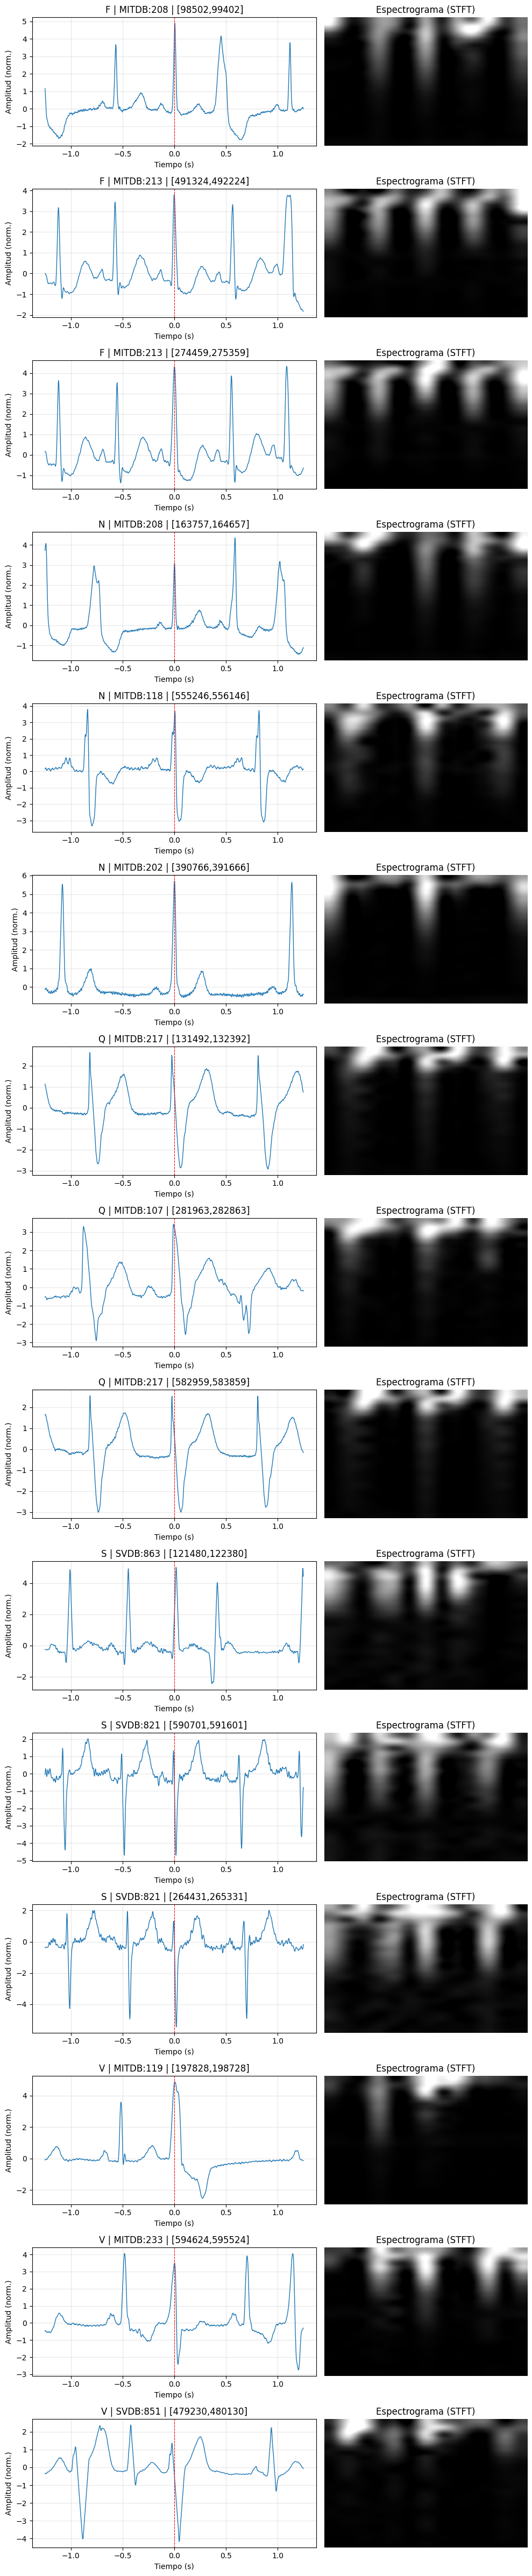

In [10]:
# ============================================================
# 6. Preview combinado: señal cruda + espectrograma
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

def _time_axis_for_window(sig_len: int, fs: int):
    """Eje de tiempo centrado en 0 (segundos)."""
    t = np.arange(sig_len) / fs
    return t - (sig_len / fs) / 2.0

def show_raw_and_spec(row, spec_cfg: SpecCfg, cmap="gray"):
    """Muestra (1) señal cruda de la ventana y (2) su espectrograma."""
    sig = np.nan_to_num(row["signal"], nan=0.0, posinf=0.0, neginf=0.0)
    fs = int(row["fs"])
    img = signal_to_spec_img(sig, fs, spec_cfg)
    t = _time_axis_for_window(len(sig), fs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.2), gridspec_kw={"width_ratios": [1.4, 1]})
    axes[0].plot(t, sig, linewidth=1.0)
    axes[0].axvline(0.0, color="r", linestyle="--", linewidth=0.8)
    axes[0].set_title(f"ECG crudo | {row['db']}:{row['record_id']} | clase {row['label']}")
    axes[0].set_xlabel("Tiempo (s)")
    axes[0].set_ylabel("Amplitud (norm.)")
    axes[0].grid(True, alpha=0.3)

    axes[1].imshow(img, cmap=cmap, aspect="auto")
    axes[1].set_title("Espectrograma (STFT)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def preview_raw_and_spec(df, per_class=3, spec_cfg: SpecCfg = SpecCfg(), seed=42, classes=None, cmap="gray"):
    """
    Muestra 'per_class' ejemplos por clase: señal cruda + espectrograma.
    """
    rng = np.random.default_rng(seed)
    classes = sorted(df["label"].unique()) if classes is None else list(classes)
    picked = []
    for c in classes:
        idxs = df.index[df["label"] == c].to_list()
        if not idxs:
            continue
        rng.shuffle(idxs)
        picked.extend(idxs[:per_class])

    if not picked:
        print("No hay ejemplos para las clases solicitadas.")
        return

    n = len(picked)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3.2 * n), squeeze=False, gridspec_kw={"width_ratios": [1.4, 1]})
    for r, idx in enumerate(picked):
        row = df.loc[idx]
        sig = np.nan_to_num(row["signal"], nan=0.0, posinf=0.0, neginf=0.0)
        fs = int(row["fs"])
        img = signal_to_spec_img(sig, fs, spec_cfg)
        t = _time_axis_for_window(len(sig), fs)

        ax0 = axes[r, 0]
        ax0.plot(t, sig, linewidth=1.0)
        ax0.axvline(0.0, color="r", linestyle="--", linewidth=0.8)
        ax0.set_title(f"{row['label']} | {row['db']}:{row['record_id']} | [{row['start_idx']},{row['end_idx']}]")
        ax0.set_xlabel("Tiempo (s)")
        ax0.set_ylabel("Amplitud (norm.)")
        ax0.grid(True, alpha=0.3)

        ax1 = axes[r, 1]
        ax1.imshow(img, cmap=cmap, aspect="auto")
        ax1.set_title("Espectrograma (STFT)")
        ax1.axis("off")

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Configuración por defecto (ajustable)
# ------------------------------------------------------------
spec_cfg = SpecCfg(
    nperseg=128,
    noverlap=64,
    nfft=None,
    window="hann",
    fmax=60.0,
    out_size=224,
    normalize="zscore_then_minmax",
    clip_percentiles=(1, 99)
)

# Un ejemplo puntual:
# show_raw_and_spec(df_windows.iloc[0], spec_cfg)

# Vista general: 3 ejemplos por clase
preview_raw_and_spec(df_windows, per_class=3, spec_cfg=spec_cfg)

### 2.4.a Manifest CSV

Crea `outputs/manifest_windows.csv` con las columnas clave de cada ventana:

- `record_id`
- Índices (`start_idx`, `end_idx`)
- `fs`
- `label`
- `symbol`
- Índice original (`df_index`)

**Propósito**: trazabilidad y reproducibilidad del procesamiento.

---

### 2.4.b Caché legible de espectrogramas

- **`spec_cache_name(row, cfg)`**: Genera un nombre de archivo humano-legible para el `.npy` que codifica la ventana y los parámetros STFT (`nperseg`, `noverlap`, `fmax`, `out_size`).

- **`save_spec_cache(...)`**: Para cada fila, si no existe el par `.npy + .json`, calcula y guarda:
  - Imagen como `.npy` (matriz `uint8` 2D).
  - Metadatos como `.json` (incluye `ids`, índices, `fs`, `label`, `symbol`).

In [11]:
# ============================================================
# 7. Manifest CSV + caché legible de espectrogramas
# ============================================================
import os, json, hashlib
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 7.1 Manifest CSV para trazabilidad
# ------------------------------------------------------------
os.makedirs("outputs", exist_ok=True)

manifest_cols = ["db", "record_id", "start_idx", "end_idx", "center_idx", "fs", "label", "symbol"]
df_manifest = (
    df_windows
    .reset_index()
    .rename(columns={"index": "df_index"})[["df_index"] + manifest_cols]
)

manifest_path = "outputs/manifest_windows.csv"
df_manifest.to_csv(manifest_path, index=False)
print("Manifest guardado en", manifest_path, "| filas:", len(df_manifest))

# ------------------------------------------------------------
# 7.2 Cache legible de espectrogramas (nombres human-readable + JSON sidecar)
# ------------------------------------------------------------
def _cfg_fingerprint(cfg: SpecCfg) -> str:
    """Hash corto para identificar la configuración de espectrograma."""
    payload = {
        "nperseg": cfg.nperseg,
        "noverlap": cfg.noverlap,
        "nfft": cfg.nfft,
        "window": cfg.window,
        "fmax": cfg.fmax,
        "out_size": cfg.out_size,
        "normalize": cfg.normalize,
        "clip": tuple(cfg.clip_percentiles),
    }
    return hashlib.sha1(json.dumps(payload, sort_keys=True).encode()).hexdigest()[:8]

def spec_cache_name(row: pd.Series, cfg: SpecCfg) -> str:
    """Nombre de archivo único y reproducible para cada espectrograma."""
    fmax_str = "none" if cfg.fmax is None else str(int(cfg.fmax))
    return (
        f"{row['record_id']}"
        f"_c{int(row['center_idx'])}"
        f"_s{int(row['start_idx'])}"
        f"_e{int(row['end_idx'])}"
        f"_{row['label']}"
        f"_n{cfg.nperseg}_o{cfg.noverlap}_f{fmax_str}_sz{cfg.out_size}"
        f"_h{_cfg_fingerprint(cfg)}.npy"
    )

def save_spec_cache(df: pd.DataFrame, out_dir: str = "outputs/specs_cache",
                    spec_cfg: SpecCfg = SpecCfg(), max_items: int | None = None) -> None:
    """Guarda espectrogramas como .npy + .json legibles, separados por base de datos."""
    it = df.iloc[:max_items] if max_items is not None else df
    saved = 0
    it = it.sort_values(["db", "record_id", "center_idx"])
    for _, r in it.iterrows():
        db_dir = os.path.join(out_dir, r["db"])
        os.makedirs(db_dir, exist_ok=True)

        fname = spec_cache_name(r, spec_cfg)
        npy_path = os.path.join(db_dir, fname)
        json_path = npy_path.replace(".npy", ".json")

        # Evita sobreescribir si ya existe
        if os.path.exists(npy_path) and os.path.exists(json_path):
            continue

        img = signal_to_spec_img(r["signal"], int(r["fs"]), spec_cfg)
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)

        np.save(npy_path, img)
        meta = {
            "db": str(r["db"]),
            "record_id": str(r["record_id"]),
            "center_idx": int(r["center_idx"]),
            "start_idx": int(r["start_idx"]),
            "end_idx": int(r["end_idx"]),
            "fs": int(r["fs"]),
            "label": str(r["label"]),
            "symbol": (None if pd.isna(r.get("symbol", None)) else str(r["symbol"])),
        }
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2, ensure_ascii=False)

        saved += 1

    print(f"[OK] Cache actualizado en '{out_dir}'. Nuevos archivos: {saved}")

# ------------------------------------------------------------
# Ejemplo de uso
# ------------------------------------------------------------
# save_spec_cache(df_windows, out_dir="outputs/specs_cache", spec_cfg=spec_cfg, max_items=20000)

Manifest guardado en outputs/manifest_windows.csv | filas: 133320


In [12]:
# ============================================================
# 8. Prueba de conversión y dataset (preview rápido)
# ============================================================

# 1) Conversión individual: señal → espectrograma
ix = 0
row = df_windows.iloc[ix]
img = signal_to_spec_img(row["signal"], int(row["fs"]), spec_cfg)
print(f"[Ejemplo {ix}] {row['db']}:{row['record_id']} | clase {row['label']}")
print("spec shape:", img.shape, "dtype:", img.dtype, "min/max:", img.min(), img.max())

# 2) Dataset mínimo (sin DataLoader aún)
labels_sorted = sorted(df_windows["label"].unique())
label2idx = {l: i for i, l in enumerate(labels_sorted)}

print("\nEtiquetas → índices:", label2idx)

# Toma una muestra aleatoria pequeña (64 ventanas) de todas las bases
ds_tmp = ECGSpecDataset(
    df_windows.sample(64, random_state=42),
    label2idx,
    spec_cfg,
    augment=False,
    return_meta=True,
    cache_dir="spec_cache_224"  # puedes dejarlo None si no quieres escribir
)

x, y, meta = ds_tmp[0]
print("\nTensor ejemplo:")
print(" shape:", tuple(x.shape), "| dtype:", x.dtype)
print(" label_id:", y.item(), f"({labels_sorted[y.item()]})")
print(" meta:", meta)

[Ejemplo 0] MITDB:100 | clase Q
spec shape: (224, 224) dtype: uint8 min/max: 0 255

Etiquetas → índices: {np.str_('F'): 0, np.str_('N'): 1, np.str_('Q'): 2, np.str_('S'): 3, np.str_('V'): 4}

Tensor ejemplo:
 shape: (3, 224, 224) | dtype: torch.float32
 label_id: 1 (N)
 meta: {'i': 0, 'db': 'MITDB', 'record_id': '114', 'center_idx': 590237, 'fs': 360, 'label': 'N', 'symbol': np.str_('N')}


# Seccion 3. Partición estratificada y agrupada (70/15/15)

### Objetivo: Split de `df_windows` en Train/Val/Test (70/15/15)

**Meta**: Dividir el dataset en proporciones 70% entrenamiento, 15% validación y 15% test, **estratificando por clase (`label`)** y **agrupando por `record_id`** para evitar fuga de datos entre particiones.

---

### Estrategia (heurística *greedy* en dos fases)

1. **Train (70%)**:
   - Selecciona grupos (`record_id`) para el conjunto de entrenamiento.
   - Criterio: maximizar la **similitud de la distribución por clase** con la distribución global.
   - El proceso intenta alcanzar aproximadamente el 70% del total de muestras.

2. **Val/Test (15%/15%)**:
   - De los grupos restantes, reparte entre Validación y Test en proporción 50/50.
   - Se mantiene la **distribución por clase** dentro de cada subconjunto.

In [13]:
# ============================================================
# 9. Utilidades para partición balanceada por clases
# ============================================================
import numpy as np
import pandas as pd

# ---------- 9.1: Utilidades de pesos/clases y métricas ----------

def _class_weights_from_global(total_cls: pd.Series, power: float = 1.0) -> pd.Series:
    """Calcula pesos inversos a la frecuencia: clases raras (S, F, Q) pesan más."""
    total = max(total_cls.sum(), 1)
    p = total_cls / total
    w = 1.0 / (p + 1e-12)
    w = w / w.mean()
    return w ** power


def _weighted_L1(sel_sum: pd.Series, target_ratio_vec: pd.Series, w: pd.Series) -> float:
    """Distancia L1 ponderada entre distribución actual y objetivo (penaliza clases raras)."""
    tot = sel_sum.sum()
    if tot <= 0:
        return np.inf
    p = sel_sum / tot
    err = (p - target_ratio_vec).abs().reindex(w.index, fill_value=0.0) * w
    return float(err.sum())


def _greedy_phase(groups, grp_cls, target_ratio, target_vec, total_all, tol, w):
    """Algoritmo greedy: selecciona grupos para aproximar distribución objetivo."""
    selected = set()
    current_sum = grp_cls.iloc[0:0].sum()  # Series ceros con mismas columnas

    for _ in range(len(groups)):
        best_g, best_score = None, np.inf
        for g in groups:
            if g in selected:
                continue
            cand_sum = current_sum + grp_cls.loc[g]
            prop_score = _weighted_L1(cand_sum, target_vec, w)
            size_ratio = cand_sum.sum() / max(total_all, 1)
            score = prop_score + abs(size_ratio - target_ratio)
            if score < best_score:
                best_g, best_score = g, score

        if best_g is None:
            break

        selected.add(best_g)
        current_sum = current_sum + grp_cls.loc[best_g]

        if current_sum.sum() >= target_ratio * total_all * (1 - tol):
            break

    return sorted(selected)

In [14]:
# ============================================================
# 10. Split estratificado y agrupado por record_id (balanceado)
# ============================================================

def stratified_group_split_weighted(
    df: pd.DataFrame,
    label_col: str = "label",
    group_col: str = "record_id",
    ratios=(0.7, 0.15, 0.15),
    tol: float = 0.02,
    seeds: int | list = 50,
    class_power: float = 1.2,
    pin_train: list[str] | None = None,
    pin_val: list[str] | None = None,
    pin_test: list[str] | None = None,
    verbose: bool = True
) -> dict[str, list[str]]:
    """
    Split por grupos (record_id o db_record_id) optimizando:
      - distribución de clases (pondera más las raras)
      - tamaño del split (70/15/15 por defecto)
    Usa múltiples seeds y devuelve el mejor split.
    """
    assert abs(sum(ratios) - 1.0) < 1e-6, "ratios debe sumar 1.0"
    if df.empty:
        return {"train": [], "val": [], "test": []}

    # --- Combinar base de datos + record_id si corresponde ---
    if "db" in df.columns and group_col != "db_record_id":
        df = df.copy()
        df["db_record_id"] = df["db"].astype(str) + "_" + df[group_col].astype(str)
        group_col = "db_record_id"

    # --- Pinned records ---
    pins_train = set([] if pin_train is None else [str(x) for x in pin_train])
    pins_val   = set([] if pin_val   is None else [str(x) for x in pin_val])
    pins_test  = set([] if pin_test  is None else [str(x) for x in pin_test])

    inter = (pins_train & pins_val) | (pins_train & pins_test) | (pins_val & pins_test)
    if inter:
        raise ValueError(f"Los siguientes record_id están anclados a más de un split: {sorted(inter)}")

    # --- Agrupar por registro y clase ---
    all_groups = df[group_col].astype(str).unique().tolist()
    grp_cls = df.groupby([group_col, label_col]).size().unstack(fill_value=0)
    grp_cls = grp_cls.reindex(all_groups, fill_value=0)

    total_cls = grp_cls.sum()
    total_all = int(total_cls.sum())
    if total_all == 0:
        return {"train": [], "val": [], "test": []}

    w = _class_weights_from_global(total_cls, power=class_power)

    # --- Seeds para búsqueda multi-start ---
    if isinstance(seeds, int):
        seeds = list(range(seeds))

    def _score_split(split) -> float:
        """Evalúa cuán bien un split respeta las proporciones globales."""
        score = 0.0
        target_vec_global = total_cls / total_all
        for part_name, target_ratio in zip(["train", "val", "test"], ratios):
            keys = split[part_name]
            if len(keys) == 0:
                return np.inf
            part_sum = grp_cls.loc[keys].sum()
            part_err = _weighted_L1(part_sum, target_vec_global, w)
            size_pen = abs(part_sum.sum()/total_all - target_ratio)
            score += part_err + size_pen
        return score

    best = (np.inf, None, None)

    fixed_all = pins_train | pins_val | pins_test
    free_groups = [g for g in all_groups if g not in fixed_all]

    for sd in seeds:
        rng = np.random.default_rng(sd)
        groups = free_groups.copy()
        rng.shuffle(groups)

        tgt_vec = total_cls / total_all
        # TRAIN
        train_free = _greedy_phase(groups, grp_cls, ratios[0], tgt_vec, total_all, tol, w)
        rem_after_train = [g for g in groups if g not in train_free]

        # VAL
        if rem_after_train:
            rem_stats = grp_cls.loc[rem_after_train]
            rem_total2 = int(rem_stats.values.sum())
            if rem_total2 > 0:
                tgt_vec_rem = rem_stats.sum() / rem_total2
                val_free = _greedy_phase(
                    rem_after_train, rem_stats,
                    ratios[1] / (ratios[1] + ratios[2] + 1e-12),
                    tgt_vec_rem, rem_total2, tol, w)
            else:
                val_free = []
        else:
            val_free = []

        test_free = sorted([g for g in rem_after_train if g not in val_free])

        split = {
            "train": sorted(list(pins_train)) + sorted(train_free),
            "val":   sorted(list(pins_val))   + sorted(val_free),
            "test":  sorted(list(pins_test))  + test_free,
        }

        s = _score_split(split)
        if s < best[0]:
            best = (s, split, sd)

    if verbose and best[1] is not None:
        print(f"[OK] Mejor seed encontrada: {best[2]} | Score: {best[0]:.5f}")

    return best[1] if best[1] is not None else {"train": [], "val": [], "test": []}

In [15]:
# ============================================================
# 11. Partición estratificada 70-15-15 por record (MITDB + SVDB)
#   * Inter-paciente: la clave de grupo es db_record_id = "{db}_{record_id}"
#   * Evita leakage entre pacientes y entre bases (MITDB/SVDB)
# ============================================================

# Asegurar columna compuesta para todo el flujo
if "db_record_id" not in df_windows.columns:
    df_windows["db_record_id"] = df_windows["db"].astype(str) + "_" + df_windows["record_id"].astype(str)

# Ejecutar split agrupado y estratificado por clases
split_ids = stratified_group_split_weighted(
    df=df_windows,
    label_col="label",
    group_col="db_record_id",   # <-- clave única por base+record (inter-paciente)
    ratios=(0.70, 0.15, 0.15),
    class_power=1.2,            # pondera más clases raras sin extremar
    seeds=100,                  # multi-start para estabilidad
    tol=0.03,                   # tolerancia de tamaño por split
    verbose=True
)

print(f"\nRegistros seleccionados: "
      f"train={len(split_ids['train'])} | val={len(split_ids['val'])} | test={len(split_ids['test'])}")

# Mapear a cada fila
record_to_split = {rid: "train" for rid in split_ids["train"]}
record_to_split.update({rid: "val" for rid in split_ids["val"]})
record_to_split.update({rid: "test" for rid in split_ids["test"]})

df_windows["split"] = df_windows["db_record_id"].astype(str).map(record_to_split).fillna("train")

# Resumen rápido por clase (%)
summary = (
    df_windows.groupby("split")["label"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .mul(100).round(2)
)
print("\nDistribución porcentual por split (%):")
print(summary)

# Guardado
df_windows.to_pickle("df_windows_mitdb_svdb_splits.pkl")
print("\n[OK] df_windows_mitdb_svdb_splits.pkl guardado correctamente.")

[OK] Mejor seed encontrada: 0 | Score: 0.20381

Registros seleccionados: train=37 | val=12 | test=30

Distribución porcentual por split (%):
label     F      N      Q      S      V
split                                  
test   0.03  38.01   7.49  26.55  27.92
train  0.86  75.17  10.49   5.47   8.00
val    0.02  67.04  13.65   8.72  10.57

[OK] df_windows_mitdb_svdb_splits.pkl guardado correctamente.


In [16]:
# ============================================================
# 12. Reportes y validaciones del split
# ============================================================

group_col = "db_record_id"
leak = df_windows.groupby(group_col)["split"].nunique().reset_index(name="n_parts")
leaky = leak[leak["n_parts"] > 1]
assert leaky.empty, f"Leakage detectado en records: {leaky[group_col].tolist()}"
print("[OK] Sin leakage entre splits por registro.\n")

sizes = df_windows["split"].value_counts().to_dict()
print("Tamaños por split:", sizes)

by = (
    df_windows.groupby(["split", "label"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["train", "val", "test"], fill_value=0)
)
print("\nConteos por clase:\n", by)

try:
    props = (by / by.sum(axis=0)).round(3)
    print("\nProporciones por clase (fila = split):\n", props)
except ZeroDivisionError:
    print("\n[Advertencia] Alguna clase no presente en un split.\n")

global_props = (
    df_windows["split"].value_counts(normalize=True)
    .reindex(["train", "val", "test"])
    .round(3)
    .to_dict()
)
print("\nProporciones globales:", global_props)

[OK] Sin leakage entre splits por registro.

Tamaños por split: {'train': 91606, 'test': 21349, 'val': 20365}

Conteos por clase:
 label    F      N     Q     S     V
split                              
train  792  68864  9609  5014  7327
val      4  13653  2780  1776  2152
test     7   8114  1599  5669  5960

Proporciones por clase (fila = split):
 label      F      N      Q      S      V
split                                   
train  0.986  0.760  0.687  0.402  0.475
val    0.005  0.151  0.199  0.143  0.139
test   0.009  0.090  0.114  0.455  0.386

Proporciones globales: {'train': 0.687, 'val': 0.153, 'test': 0.16}


In [17]:
# ============================================================
# Función auxiliar: reparar balance VAL <-> TEST (mantiene TRAIN fijo)
# ============================================================

def repair_val_test_balance(df: pd.DataFrame,
                            class_power: float = 1.2,
                            max_iters: int = 400,
                            verbose: bool = False) -> pd.Series:
    """
    Intercambia registros entre val y test hasta que sus distribuciones de clases
    sean similares y el tamaño total por split se mantenga.
    TRAIN nunca se altera.
    """
    df = df.copy()
    group_col = "db_record_id"
    grp_cls = df.groupby([group_col, "label"]).size().unstack(fill_value=0)
    total_cls = grp_cls.sum()
    total_all = total_cls.sum()
    w = _class_weights_from_global(total_cls, power=class_power)

    # Subconjuntos iniciales
    val_ids = set(df.loc[df["split"] == "val", group_col])
    test_ids = set(df.loc[df["split"] == "test", group_col])

    def _score(sub_ids):
        if len(sub_ids) == 0:
            return np.inf
        sel = grp_cls.loc[list(sub_ids)]
        return _weighted_L1(sel.sum(), total_cls / total_all, w)

    score_val = _score(val_ids)
    score_test = _score(test_ids)
    if verbose:
        print(f"[Inicio] score_val={score_val:.4f} | score_test={score_test:.4f}")

    for _ in range(max_iters):
        improved = False
        worst_split = "val" if score_val > score_test else "test"
        src_ids = val_ids if worst_split == "val" else test_ids
        dst_ids = test_ids if worst_split == "val" else val_ids
        best_gain = 0
        best_id = None

        for rid in list(src_ids):
            new_src = src_ids - {rid}
            new_dst = dst_ids | {rid}
            s_src = _score(new_src)
            s_dst = _score(new_dst)
            gain = (score_val + score_test) - (s_src + s_dst)
            if gain > best_gain:
                best_gain, best_id = gain, rid

        if best_gain > 1e-6 and best_id is not None:
            if worst_split == "val":
                val_ids.remove(best_id); test_ids.add(best_id)
            else:
                test_ids.remove(best_id); val_ids.add(best_id)
            score_val = _score(val_ids)
            score_test = _score(test_ids)
            improved = True
            if verbose:
                print(f"Iter OK gain={best_gain:.5f} | scores=({score_val:.4f},{score_test:.4f})")

        if not improved:
            break

    new_split = df["split"].copy()
    new_split.loc[df[group_col].isin(val_ids)] = "val"
    new_split.loc[df[group_col].isin(test_ids)] = "test"
    return new_split

In [18]:
# ============================================================
# 13. Ajuste final de split + reparación + fine-tuning de tamaños
# ============================================================

# NO re-calculamos split aquí. Solo reparamos y ajustamos tamaños.
df_windows["split"] = repair_val_test_balance(
    df_windows, class_power=1.2, max_iters=400, verbose=True
)

def fine_tune_val_test_sizes(df, target_ratio_val=0.15, target_ratio_test=0.15, max_steps=50):
    """Ajusta el tamaño de val/test manteniendo train fijo."""
    df = df.copy()
    total = len(df)
    target_val = int(round(total * target_ratio_val))
    target_test = int(round(total * target_ratio_test))

    group_col = "db_record_id"
    per_rec = df.groupby([group_col, "split"]).size().unstack(fill_value=0)
    val_ids = set(df.loc[df["split"] == "val", group_col].astype(str).unique())
    test_ids = set(df.loc[df["split"] == "test", group_col].astype(str).unique())

    cur_val = int(df["split"].eq("val").sum())
    cur_test = int(df["split"].eq("test").sum())

    steps = 0
    while steps < max_steps and (cur_val != target_val or cur_test != target_test):
        steps += 1
        if cur_val > target_val and val_ids:
            cand = min(val_ids, key=lambda rid: per_rec.loc[rid, "val"] if "val" in per_rec.columns else 0)
            moved = int(per_rec.loc[cand, "val"])
            if moved == 0:
                val_ids.remove(cand); continue
            df.loc[df[group_col].astype(str) == cand, "split"] = "test"
            val_ids.remove(cand); test_ids.add(cand)
            cur_val -= moved; cur_test += moved
        elif cur_test > target_test and test_ids:
            cand = min(test_ids, key=lambda rid: per_rec.loc[rid, "test"] if "test" in per_rec.columns else 0)
            moved = int(per_rec.loc[cand, "test"])
            if moved == 0:
                test_ids.remove(cand); continue
            df.loc[df[group_col].astype(str) == cand, "split"] = "val"
            test_ids.remove(cand); val_ids.add(cand)
            cur_test -= moved; cur_val += moved
        else:
            break
    return df["split"]

df_windows["split"] = fine_tune_val_test_sizes(
    df_windows, target_ratio_val=0.15, target_ratio_test=0.15, max_steps=30
)

sizes = (
    df_windows["split"]
    .value_counts(normalize=True)
    .reindex(["train", "val", "test"])
    .round(3)
    .to_dict()
)
print("Proporciones globales (esperado ~0.70/0.15/0.15):", sizes)

by = (
    df_windows.groupby(["split", "label"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["train", "val", "test"])
)
print("\nConteos por clase:\n", by)
print("\nProporciones por clase (fila = split):\n", (by / by.sum(axis=0)).round(3))

group_col = "db_record_id"
recs_train = sorted(df_windows.loc[df_windows["split"] == "train", group_col].astype(str).unique())
recs_val   = sorted(df_windows.loc[df_windows["split"] == "val", group_col].astype(str).unique())
recs_test  = sorted(df_windows.loc[df_windows["split"] == "test", group_col].astype(str).unique())

print(f"\nRegistros en TRAIN ({len(recs_train)}):", recs_train)
print(f"Registros en VAL   ({len(recs_val)}):", recs_val)
print(f"Registros en TEST  ({len(recs_test)}):", recs_test)

df_windows.to_pickle("df_windows_mitdb_svdb_splits_final.pkl")
print("\n[OK] Partición final guardada en df_windows_mitdb_svdb_splits_final.pkl")

[Inicio] score_val=0.0418 | score_test=0.1061
Iter OK gain=0.00466 | scores=(0.0400,0.1032)
Iter OK gain=0.00003 | scores=(0.0421,0.1011)
Proporciones globales (esperado ~0.70/0.15/0.15): {'train': 0.687, 'val': 0.148, 'test': 0.165}

Conteos por clase:
 label    F      N     Q     S     V
split                              
train  792  68864  9609  5014  7327
val      4  13653  2948  1274  1893
test     7   8114  1431  6171  6219

Proporciones por clase (fila = split):
 label      F      N      Q      S      V
split                                   
train  0.986  0.760  0.687  0.402  0.475
val    0.005  0.151  0.211  0.102  0.123
test   0.009  0.090  0.102  0.495  0.403

Registros en TRAIN (37): ['MITDB_100', 'MITDB_102', 'MITDB_104', 'MITDB_105', 'MITDB_106', 'MITDB_109', 'MITDB_112', 'MITDB_116', 'MITDB_118', 'MITDB_119', 'MITDB_122', 'MITDB_200', 'MITDB_201', 'MITDB_202', 'MITDB_203', 'MITDB_205', 'MITDB_207', 'MITDB_208', 'MITDB_209', 'MITDB_210', 'MITDB_212', 'MITDB_213', 'MITDB

In [19]:
# ============================================================
# 14. SMOTE 1D SOLO para clase F (solo en TRAIN, sin leakage)
# ============================================================
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# 14.1 — Tomar SOLO ventanas del split TRAIN
df_tr = df_windows[df_windows["split"] == "train"].copy()

# 14.2 — Contar clases en TRAIN para definir objetivo de F
cls_counts = df_tr["label"].value_counts().to_dict()
nF = int(cls_counts.get("F", 0))
nS = int(cls_counts.get("S", 0))
nV = int(cls_counts.get("V", 0))
nQ = int(cls_counts.get("Q", 0))
nN = int(cls_counts.get("N", 0))

# Objetivo: igualar F a la clase minoritaria entre S/V/Q (elige una de estas dos líneas)
target_F = max(nF, min(nS, nV, nQ))                 # Opción A: llevar F al mínimo de (S,V,Q)
# target_F = max(nF, int(0.20 * nN))                # Opción B: llevar F al ~20% de N (comenta o descomenta)

n_new = target_F - nF
if n_new <= 0:
    print(f"[SMOTE] No se generan muestras: F ya tiene {nF} ≥ objetivo {target_F}.")
else:
    print(f"[SMOTE] Generando ~{n_new} ventanas sintéticas de F (objetivo {target_F}).")

    # 14.3 — Construir matriz de características X (flatten de la señal 1D)
    # SMOTE exige >= 2 clases: usamos F y una muestra de N como vecindario "de contexto",
    # pero SOLO se sobre-muestreará F con sampling_strategy={'F': target_F}.
    T = int(df_tr.iloc[0]["signal"].shape[0])
    df_F = df_tr[df_tr["label"] == "F"]
    df_N = df_tr[df_tr["label"] == "N"].sample(min(5000, nN), random_state=42) if nN > 0 else df_tr[df_tr["label"] != "F"].sample(min(5000, len(df_tr)-len(df_F)), random_state=42)

    X_F = np.stack(df_F["signal"].to_list(), axis=0).astype(np.float32)  # [nF, T]
    y_F = np.array(["F"] * len(df_F), dtype=object)

    X_N = np.stack(df_N["signal"].to_list(), axis=0).astype(np.float32)
    y_N = np.array(["N"] * len(df_N), dtype=object)

    X_train = np.concatenate([X_F, X_N], axis=0)           # [nF+nN, T]
    y_train = np.concatenate([y_F, y_N], axis=0)           # ['F','N',...]

    # 14.4 — Aplicar SMOTE SOLO a F
    # Ajusta k_neighbors si F es MUY escasa (2–5). Si da error por vecinos, baja k.
    k_neighbors = min(5, max(2, len(df_F) - 1))
    sm = SMOTE(sampling_strategy={"F": int(target_F)}, k_neighbors=k_neighbors, random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # 14.5 — Extraer SOLO las nuevas F sintéticas
    # (las reales quedan al inicio, las nuevas quedan al final para la clase sobre-muestreada)
    # Índices de F en re-muestreo:
    idx_F_res = np.where(y_res == "F")[0]
    nF_res = len(idx_F_res)
    n_synth = nF_res - nF
    if n_synth <= 0:
        print("[SMOTE] No se generaron F sintéticas (posible límite de vecinos).")
    else:
        X_F_res = X_res[idx_F_res]
        X_F_new = X_F_res[-n_synth:]                      # últimas son las nuevas
        print(f"[SMOTE] F sintéticas creadas: {n_synth}")

        # 14.6 — Construir filas nuevas para df_windows (solo TRAIN)
        # No re-usamos record_id reales para evitar confusiones; asignamos un "grupo" artificial
        # (no afecta porque YA hiciste el split; esto no se re-splitea).
        base_center = 1_000_000_000  # ID artificial alto para no colisionar
        rows_new = []
        for i, sig_new in enumerate(X_F_new):
            rows_new.append({
                "db": "AUG",                         # marca clara de procedencia
                "record_id": "SMOTE_F",
                "fs": int(df_tr.iloc[0]["fs"]),      # todas tus ventanas están a 360 Hz
                "start_idx": 0,                      # campos dummy (no usados después)
                "end_idx": int(T),
                "center_idx": base_center + i,       # ID único
                "signal": sig_new.astype(np.float32),
                "label": "F",
                "symbol": "F",
                "db_record_id": "AUG_SMOTE_F",       # clave de grupo sintética
                "split": "train"                     # IMPORTANTÍSIMO: solo en TRAIN
            })
        df_newF = pd.DataFrame(rows_new)

        # 14.7 — Añadir al dataframe maestro
        prev_len = len(df_windows)
        df_windows = pd.concat([df_windows, df_newF], ignore_index=True)
        print(f"[SMOTE] df_windows: {prev_len} -> {len(df_windows)} (añadidas {len(df_newF)} filas)")

        # 14.8 — (Opcional) guardar versión con SMOTE
        df_windows.to_pickle("df_windows_mitdb_svdb_splits_SMOTE_F.pkl")
        print("[OK] Guardado df_windows_mitdb_svdb_splits_SMOTE_F.pkl")


[SMOTE] Generando ~4222 ventanas sintéticas de F (objetivo 5014).
[SMOTE] F sintéticas creadas: 4222
[SMOTE] df_windows: 133320 -> 137542 (añadidas 4222 filas)
[OK] Guardado df_windows_mitdb_svdb_splits_SMOTE_F.pkl


In [20]:
print("\n[Post-SMOTE] Conteos por split/clase:")
print(df_windows.groupby(["split","label"]).size().unstack(fill_value=0))


[Post-SMOTE] Conteos por split/clase:
label     F      N     Q     S     V
split                               
test      7   8114  1431  6171  6219
train  5014  68864  9609  5014  7327
val       4  13653  2948  1274  1893


Distribución GLOBAL (conteos):
label
F     5025
N    90631
Q    13988
S    12459
V    15439

Distribución GLOBAL (%):
label
F     3.65
N    65.89
Q    10.17
S     9.06
V    11.22


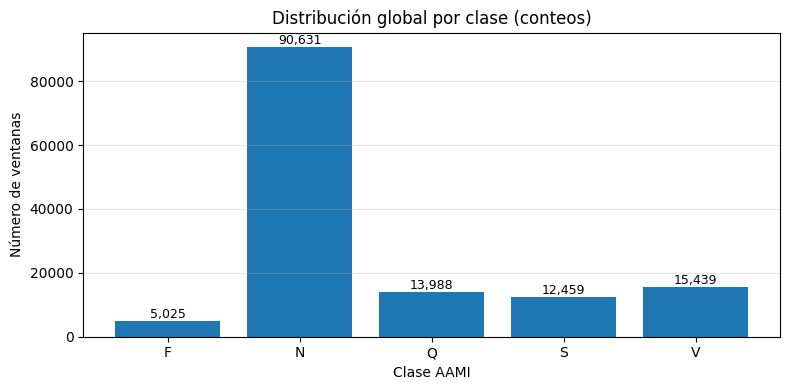


Conteos por split y clase:
label     F      N     Q     S     V
split                               
train  5014  68864  9609  5014  7327
val       4  13653  2948  1274  1893
test      7   8114  1431  6171  6219


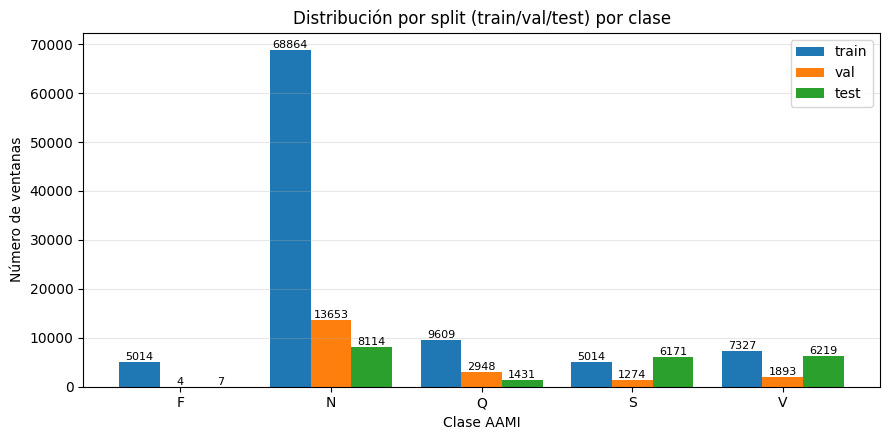


Proporciones por clase (fila = split, columna = clase):
label      F      N      Q      S      V
split                                   
train  0.998  0.760  0.687  0.402  0.475
val    0.001  0.151  0.211  0.102  0.123
test   0.001  0.090  0.102  0.495  0.403


In [21]:
# ============================================================
# Visualización: distribución de clases (global y por split)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar orden consistente de etiquetas
labels_sorted = sorted(df_windows["label"].astype(str).unique())

# ---------- 1) Distribución GLOBAL ----------
counts = df_windows["label"].astype(str).value_counts().reindex(labels_sorted, fill_value=0)
total = int(counts.sum())
perc = (counts / max(total, 1) * 100).round(2)

print("Distribución GLOBAL (conteos):")
print(counts.to_string())
print("\nDistribución GLOBAL (%):")
print(perc.to_string())

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(counts.index.astype(str), counts.values)
ax.set_title("Distribución global por clase (conteos)")
ax.set_xlabel("Clase AAMI")
ax.set_ylabel("Número de ventanas")
ax.grid(axis="y", alpha=0.3)

# anotar valores encima de cada barra
for rect, val in zip(bars, counts.values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{val:,}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# ---------- 2) Distribución POR SPLIT (barras agrupadas) ----------
pivot = (
    df_windows.groupby(["split","label"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["train","val","test"], columns=labels_sorted, fill_value=0)
)

print("\nConteos por split y clase:")
print(pivot)

# series para las barras
train_counts = pivot.loc["train"].values if "train" in pivot.index else np.zeros(len(labels_sorted), dtype=int)
val_counts   = pivot.loc["val"].values   if "val"   in pivot.index else np.zeros(len(labels_sorted), dtype=int)
test_counts  = pivot.loc["test"].values  if "test"  in pivot.index else np.zeros(len(labels_sorted), dtype=int)

x = np.arange(len(labels_sorted))
width = 0.27

fig, ax = plt.subplots(figsize=(9, 4.5))
b1 = ax.bar(x - width, train_counts, width, label="train")
b2 = ax.bar(x,         val_counts,   width, label="val")
b3 = ax.bar(x + width, test_counts,  width, label="test")

ax.set_xticks(x)
ax.set_xticklabels(labels_sorted)
ax.set_xlabel("Clase AAMI")
ax.set_ylabel("Número de ventanas")
ax.set_title("Distribución por split (train/val/test) por clase")
ax.legend()
ax.grid(axis="y", alpha=0.3)

# anotar valores (opcional)
def _annotate(ax, bars):
    for r in bars:
        h = r.get_height()
        if h > 0:
            ax.text(r.get_x()+r.get_width()/2, h, f"{int(h)}", ha="center", va="bottom", fontsize=8)

_annotate(ax, b1); _annotate(ax, b2); _annotate(ax, b3)

plt.tight_layout()
plt.show()

# ---------- 3) Proporciones por split (tabla rápida) ----------
props = (pivot / pivot.sum(axis=0)).round(3)
print("\nProporciones por clase (fila = split, columna = clase):")
print(props)

# Partición de datos (MITDB + SVDB): qué hacemos, por qué y cómo lo justificamos

## 1️ Objetivo del *split*
- Entrenar y evaluar un modelo de clasificación **AAMI (N/S/V/F/Q)** en ECG de forma **inter-paciente**, es decir:  
  **ningún paciente aparece en más de un conjunto (train/val/test)**.  
  Esto evita *leakage* y asegura una evaluación clínica realista.  
- Mantener **proporciones razonables de cada clase** en los tres conjuntos para evitar sesgos de entrenamiento o validación.

---

## 2️ Particularidades de los datasets

### **MIT-BIH Arrhythmia Database (MITDB)**
- 48 registros (~30 min cada uno, 360 Hz) de 47 pacientes.
- Mezcla variada de ritmos, pero con **claro predominio de la clase N (Normal)**.

### **MIT-BIH Supraventricular Arrhythmia Database (SVDB)**
- 78 registros seleccionados **para “suplementar” las arritmias supraventriculares** (clase S).
- En la práctica, contiene **muchos latidos S** y también bastantes **V (ventriculares)**.

**Conclusión:**  
SVDB está **sesgado hacia clases raras (S y V)**, mientras MITDB domina **N**.  
Si un split contiene más registros SVDB, mostrará más S/V.  
Si contiene más MITDB, estará dominado por N.  
Este es un **sesgo por dominio**, no un error.

---

## 3️ Diseño de la solución

### 3.1 — Split inter-paciente
Agrupamos por `record_id` (y por `db_record_id` cuando hay varias bases)  
para garantizar que **cada paciente/registros** se use en **un solo split**.

---

### 3.2 — Estratificación con ponderación por clases raras
Usamos un algoritmo *greedy* que selecciona grupos minimizando una  
**distancia L1 ponderada** entre la distribución de clases de cada split  
y la distribución global.  
Las clases raras (S, V, F) tienen más peso (`class_power` > 1),  
para que no desaparezcan de validación o test.

---

### 3.3 — Balance por cantidad de *ventanas*, no de *registros*
Cada registro tiene distinto número de latidos.  
Por eso medimos proporciones sobre **`df_windows`** (ventanas reales)  
y no sobre `df_beats` ni sobre registros.  
Esto asegura que la proporción 70/15/15 se cumpla **por volumen de datos efectivo**,  
no solo por cantidad de archivos.

---

### 3.4 — Reparación Val ↔ Test (manteniendo Train fijo)
Después del primer split:
- Se intercambian registros completos entre Val y Test  
  cuando mejora la similitud de distribuciones (Train nunca cambia).
- Se aplica un ajuste fino para acercarse al tamaño ideal (≈ 15 % / 15 %).

---

### 3.5 — Split por base (MITDB y SVDB) y unión final *(opcional y recomendado)*
Para evitar que un split quede dominado por una base,
se genera el 70/15/15 dentro de cada base por separado  
y luego se **unen los splits homónimos**.  
Así cada conjunto (train, val, test) contiene tanto MITDB como SVDB  
en proporciones parecidas.

---

## 4️ Resultados esperados

- **Proporciones globales** ≈ 0.70 / 0.15 / 0.15 (medidas en ventanas).  
- **Proporciones por clase** similares entre splits (sin que S/V se concentren en test).  
- **Sin leakage:** cada `record_id` pertenece a un único split.  
- Reporte con:
  - conteos por clase y split,
  - proporciones por clase (fila = split),
  - verificación visual (heatmap) para comprobar uniformidad.

---

## 5️ Resumen justificativo

- Se cumple el estándar **AAMI EC57** (clases N/S/V/F/Q).  
- Se usa evaluación **inter-paciente** para evitar optimismo artificial.  
- Se balancea por **volumen real de datos (ventanas)**, no solo por registros.  
- Se aplica **reparación Val/Test** y **ajuste de tamaños** sin tocar Train.  
- Se mitiga el **sesgo de dominio** entre MITDB (domina N) y SVDB (domina S/V).  
- Con esto, el split es:
  - clínicamente válido,
  - estadísticamente equilibrado,
  - y representativo del comportamiento real del modelo.

---

### Conclusión
Esta estrategia de partición:
1. Garantiza separación **inter-paciente** (sin fugas).
2. Mantiene la **distribución de clases AAMI** en todos los conjuntos.
3. Corrige el **desbalance por dominio** entre MITDB y SVDB.
4. Produce splits **70 / 15 / 15 estables** por cantidad real de datos.

En resumen:  
la partición resultante es **honesta, balanceada y clínicamente interpretativa**,  
listas las bases para un entrenamiento robusto y evaluaciones confiables.

# Seccion 4. Modelos (ResNet/MobileNet/EfficientNet)

In [22]:
# ============================================================
# Sección 4 — Label mappings, class weights y DataLoaders seguros (versión robusta)
# ============================================================

import math
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

# ---------- 4.1: Label mapping y class weights ----------

def build_label_mappings(df, label_col="label"):
    """Deriva labels ordenados y mapeos (label2idx / idx2label)."""
    labels_sorted = sorted(df[label_col].astype(str).unique())
    label2idx = {l: i for i, l in enumerate(labels_sorted)}
    idx2label = {i: l for l, i in label2idx.items()}
    return labels_sorted, label2idx, idx2label


def compute_class_weights_from_train(df_train, labels_sorted, label_col="label"):
    """
    Calcula pesos inversos a la frecuencia sobre TRAIN.
    Normaliza para media ≈ 1 y blinda contra NaN/Inf/extremos.
    """
    vc = df_train[label_col].astype(str).value_counts()
    total = int(vc.sum())
    weights = []
    for lbl in labels_sorted:
        c = int(vc.get(lbl, 0))
        w = total / max(c, 1)
        weights.append(w)
    mean_w = sum(weights) / len(weights) if weights else 1.0
    weights = [w / mean_w for w in weights]
    class_weights = torch.tensor(weights, dtype=torch.float32)

    # Blindaje robusto
    class_weights = torch.nan_to_num(class_weights, nan=1.0, posinf=10.0, neginf=1.0)
    class_weights = torch.clamp(class_weights, min=1e-6, max=10.0)
    return class_weights


# ---------- 4.2: Crear datasets ----------

def make_datasets(df_windows, label2idx, spec_cfg,
                  aug_train=True, aug_val=False, aug_test=False,
                  return_meta=True):
    """Crea datasets para train/val/test usando ECGSpecDataset."""
    df_tr = df_windows[df_windows["split"] == "train"].reset_index(drop=True)
    df_va = df_windows[df_windows["split"] == "val"].reset_index(drop=True)
    df_te = df_windows[df_windows["split"] == "test"].reset_index(drop=True)

    ds_tr = ECGSpecDataset(df_tr, label2idx, spec_cfg,
                           augment=aug_train,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/train")
    ds_va = ECGSpecDataset(df_va, label2idx, spec_cfg,
                           augment=aug_val,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/val")
    ds_te = ECGSpecDataset(df_te, label2idx, spec_cfg,
                           augment=aug_test,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/test")
    return ds_tr, ds_va, ds_te


# ---------- 4.3: DataLoaders seguros y optimizados (versión robusta) ----------

def _seed_worker(worker_id):
    """Semilla por worker para reproducibilidad cuando num_workers>0."""
    import random, numpy as np
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

import multiprocessing
from torch.utils.data import DataLoader, WeightedRandomSampler

def make_dataloaders_safe(
    ds_tr, ds_va, ds_te,
    batch_size=64,
    use_weighted_sampler=False,
    base_seed: int = 42,
    prefer_fast_workers: bool = True,
    minority_boost: float = 2.0,
):
    """
    DataLoaders optimizados para aprovechar todos los núcleos disponibles.
    - prefer_fast_workers=True: usa multiprocessing también en Windows.
    - prefer_fast_workers=False: config "a prueba de todo" (workers=0).
    """
    is_windows = (os.name == "nt")
    is_cuda = torch.cuda.is_available()
    num_cores = multiprocessing.cpu_count()

    if prefer_fast_workers:
        # Heurística: usa casi todos los núcleos, deja 1-2 para el SO
        # En PCs de 12 núcleos → típicamente 10
        num_workers = max(4, num_cores - 2)
        # Si quieres capar por RAM o I/O, puedes limitar:
        # num_workers = min(num_workers, 12)
    else:
        # Modo ultra seguro (evita multiprocessing)
        num_workers = 0

    # En Windows, multiprocessing funciona con 'spawn'; en scripts .py
    # conviene envolver con if __name__ == "__main__": (en notebooks no aplica).
    # https://discuss.pytorch.org/t/if-name-main-for-window10/19377
    if is_windows and not prefer_fast_workers:
        num_workers = 0

    pin_memory = bool(is_cuda and num_workers > 0)
    persistent_workers = bool(num_workers > 0)

    sampler = None
    g = torch.Generator()
    g.manual_seed(base_seed)

    if use_weighted_sampler:
        labels_array = ds_tr.df["label"].map(ds_tr.label2idx).to_numpy()
        from collections import Counter
        y_counts = Counter(labels_array)

        # Pesos inversos a la frecuencia
        w_per_class = {cls: 1.0 / max(cnt, 1) for cls, cnt in y_counts.items()}

        # ↑ Refuerzo a minoritarias usando el parámetro minority_boost
        if "S" in ds_tr.label2idx:
            w_per_class[ds_tr.label2idx["S"]] *= float(minority_boost)
        if "F" in ds_tr.label2idx:
            w_per_class[ds_tr.label2idx["F"]] *= float(minority_boost)

        # Pesos por ejemplo (CPU, dtype double está OK para el sampler)
        example_weights = torch.as_tensor(
            [w_per_class[int(lbl)] for lbl in labels_array],
            dtype=torch.double
        )

        # Normalización y clamp para estabilidad numérica
        example_weights = example_weights / example_weights.mean()
        example_weights = torch.clamp(example_weights, min=1e-3, max=1e3)

        sampler = WeightedRandomSampler(
            example_weights,
            num_samples=len(example_weights),
            replacement=True
        )

    common = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        drop_last=False,
        generator=g,
        worker_init_fn=_seed_worker if num_workers > 0 else None,
    )
    if num_workers > 0:
        common["prefetch_factor"] = 2  # solo si hay workers

    # Nota: DataLoader ignora prefetch_factor si num_workers=0 (OK)
    dl_tr = DataLoader(ds_tr, sampler=sampler, shuffle=(sampler is None), **common)
    dl_va = DataLoader(ds_va, shuffle=False, **common)
    dl_te = DataLoader(ds_te, shuffle=False, **common)

    print(f" DataLoaders | workers={num_workers} | pin_memory={pin_memory} | "
          f"persistent={persistent_workers} | prefetch_factor={common['prefetch_factor']}")
    return dl_tr, dl_va, dl_te

# ---------- 4.4: Construcción completa y verificación ----------

# Construir mapeos de etiquetas
labels_sorted, label2idx, idx2label = build_label_mappings(df_windows, label_col="label")
print("labels_sorted:", labels_sorted)
print("label2idx:", label2idx)

# Crear datasets
ds_train, ds_val, ds_test = make_datasets(
    df_windows, label2idx, spec_cfg,
    aug_train=True, aug_val=False, aug_test=False,
    return_meta=True
)

# Calcular pesos de clases (TRAIN)
class_weights = compute_class_weights_from_train(
    df_windows[df_windows["split"] == "train"],
    labels_sorted,
    label_col="label"
)
print("\n class_weights calculados (orden labels_sorted):", class_weights.tolist())

ratio = (class_weights.max() / class_weights.min()).item()
print(f"   ratio max/min: {ratio:.3f}")

for lbl, w in zip(labels_sorted, class_weights.tolist()):
    print(f"  {lbl}: {w:.3f}")

if ratio > 20:
    print(" Pesos muy desbalanceados, aplicando clamp(min=0.1, max=10.0)...")
    class_weights = torch.clamp(class_weights.clone(), min=0.1, max=10.0)
    new_ratio = (class_weights.max() / class_weights.min()).item()
    print("→ class_weights corregidos:", class_weights.tolist())
    print(f"   nuevo ratio max/min: {new_ratio:.3f}")
else:
    print(" Pesos dentro de rango razonable.")

# IMPORTANTE: cuando instancies la pérdida, muévela al mismo device del modelo
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# Crear DataLoaders seguros (con muestreo balanceado)
dl_train, dl_val, dl_test = make_dataloaders_safe(
    ds_train, ds_val, ds_test,
    batch_size=64,
    use_weighted_sampler=True,
    prefer_fast_workers=True,
    minority_boost=6.0  # si se  aplica SMOTE a F, baja el boost (p.ej. 5–8)
)

print("\n Loaders seguros creados (num_workers ajustado automáticamente).")
print(f"Train batches: {math.ceil(len(ds_train) / 64)} | "
      f"Val: {math.ceil(len(ds_val) / 64)} | Test: {math.ceil(len(ds_test) / 64)}")

# Verificación estricta de batches (3 lotes)
num_classes = len(labels_sorted)
_checked = 0
for xb, yb, *_ in dl_train:
    if not torch.isfinite(xb).all():
        raise RuntimeError("Batch con NaN/Inf en X detectado.")
    if not torch.isfinite(yb.float()).all():
        raise RuntimeError("Batch con NaN/Inf en y detectado.")
    if xb.min() < 0 or xb.max() > 1:
        print("Aviso: rango de imágenes fuera de [0,1]. "
              "Considera aplicar torch.clamp dentro de tu Dataset.")
    if yb.dtype != torch.long:
        raise TypeError(f"Etiquetas con dtype {yb.dtype}, se requiere torch.long para CrossEntropyLoss.")
    if yb.min().item() < 0 or yb.max().item() >= num_classes:
        raise ValueError(f"Etiqueta fuera de rango [0,{num_classes-1}] detectada en el batch.")
    _checked += 1
    if _checked >= 3:
        break
print(" Verificación de 3 batches OK (datos finitos y etiquetas válidas).")

labels_sorted: [np.str_('F'), np.str_('N'), np.str_('Q'), np.str_('S'), np.str_('V')]
label2idx: {np.str_('F'): 0, np.str_('N'): 1, np.str_('Q'): 2, np.str_('S'): 3, np.str_('V'): 4}

 class_weights calculados (orden labels_sorted): [1.524887204170227, 0.1110273078083992, 0.7956899404525757, 1.524887204170227, 1.0435081720352173]
   ratio max/min: 13.734
  F: 1.525
  N: 0.111
  Q: 0.796
  S: 1.525
  V: 1.044
 Pesos dentro de rango razonable.
 DataLoaders | workers=10 | pin_memory=True | persistent=True | prefetch_factor=2

 Loaders seguros creados (num_workers ajustado automáticamente).
Train batches: 1498 | Val: 309 | Test: 343
 Verificación de 3 batches OK (datos finitos y etiquetas válidas).


In [23]:
# ---------- 4.5: Construcción de caché (sin cambios en lógica, ya correcto) ----------
from tqdm import tqdm

CACHE_ROOT = Path("./spec_cache_224")
CACHE_ROOT.mkdir(parents=True, exist_ok=True)

def build_spec_cache(df_split, split_name, func_signal_to_img, spec_cfg):
    """
    Genera y guarda los espectrogramas en ./spec_cache_224/{split_name}/{db}/{row_id}.png
    (coincide con ECGSpecDataset).
    """
    cfgh = _cfg_fingerprint(spec_cfg)
    
    outdir = CACHE_ROOT / split_name
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"→ Construyendo caché para '{split_name}' en {outdir}")

    for i, row in tqdm(df_split.reset_index(drop=True).iterrows(), total=len(df_split)):
        dbname = str(row["db"])
        row_id = f"{dbname}_{row['record_id']}_{int(row['center_idx'])}_h{cfgh}"  # igual al ECGSpecDataset
        outdir_db = outdir / dbname
        outdir_db.mkdir(parents=True, exist_ok=True)

        p = outdir_db / f"{row_id}.png"
        if p.exists():
            continue

        img = func_signal_to_img(row["signal"], int(row["fs"]), spec_cfg)
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
        ok = cv2.imwrite(str(p), img)
        if not ok:
            raise IOError(f"Fallo al escribir {p}")


    total_png = sum(1 for _ in outdir.rglob("*.png"))
    print(f"Caché '{split_name}' lista: {total_png} archivos.\n")

# (Ejecutar una vez si se quiere volver a generar el cache)
# build_spec_cache(df_windows[df_windows["split"]=="train"], "train", signal_to_spec_img, spec_cfg)
# build_spec_cache(df_windows[df_windows["split"]=="val"],   "val",   signal_to_spec_img, spec_cfg)
# build_spec_cache(df_windows[df_windows["split"]=="test"],  "test",  signal_to_spec_img, spec_cfg)

In [24]:
# ============================================================
# 4.6 Factoría de modelos (ResNet50 / MobileNetV3-Large / EfficientNetV2-B0)
# ============================================================

import torch
import torch.nn as nn
import torchvision.models as tvm

def _set_classifier_out(in_features: int, num_classes: int) -> nn.Linear:
    """Devuelve una capa lineal para el clasificador final."""
    layer = nn.Linear(in_features, num_classes)
    nn.init.xavier_uniform_(layer.weight)
    nn.init.zeros_(layer.bias)
    return layer


# === Build model con Dropout tunable en la head (ResNet50, MobileNetV3-Large, EfficientNetV2-B0) ===
import torch.nn as nn
import torchvision.models as tvm

def build_model(
    arch: str,
    num_classes: int = 5,
    pretrained: bool = True,
    dropout_rate: float = 0.3
) -> nn.Module:
    """
    Crea un modelo con pesos preentrenados y ajusta la cabeza de clasificación
    con Dropout tunable (0.2–0.4 recomendado). Soporta:
      - resnet50
      - mobilenet_v3_large
      - efficientnet_v2_b0
    """
    arch = arch.lower()

    # ---------- ResNet-50 ----------
    if arch == "resnet50":
        try:
            weights = tvm.ResNet50_Weights.DEFAULT if pretrained else None
            model = tvm.resnet50(weights=weights)
        except Exception:
            model = tvm.resnet50(pretrained=pretrained)

        in_f = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_f, num_classes),
        )
        return model

    # ---------- MobileNet V3-Large ----------
    if arch in {"mobilenet_v3_large", "mobilenetv3-large", "mobilenetv3_large"}:
        try:
            weights = tvm.MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
            model = tvm.mobilenet_v3_large(weights=weights)
        except Exception:
            model = tvm.mobilenet_v3_large(pretrained=pretrained)

        # Mantener 960→1280; tunear Dropout y última Linear (1280→C)
        # Estructura oficial: Linear(960→1280) → Hardswish → Dropout → Linear(1280→C)
        model.classifier[2].p = dropout_rate                # Dropout tunable
        model.classifier[-1] = nn.Linear(1280, num_classes) # salida final
        return model

    # ---------- EfficientNet V2-B0 ----------
    if arch in {"efficientnetv2_b0", "efficientnet-v2-b0", "efficientnet_v2_b0"}:
        # Preferir timm si está disponible (acepta drop_rate directo)
        try:
            import timm
            model = timm.create_model(
                "efficientnetv2_b0",
                pretrained=pretrained,
                num_classes=num_classes,
                drop_rate=dropout_rate
            )
            return model
        except Exception:
            # Fallback: Torchvision
            try:
                weights = tvm.EfficientNet_V2_B0_Weights.DEFAULT if pretrained else None
                model = tvm.efficientnet_v2_b0(weights=weights)
            except Exception:
                # Compatibilidad con versiones viejas (B0 clásico)
                try:
                    weights = tvm.EfficientNet_B0_Weights.DEFAULT if pretrained else None
                    model = tvm.efficientnet_b0(weights=weights)
                except Exception:
                    model = tvm.efficientnet_b0(pretrained=pretrained)

            # Torchvision EfficientNet(V2) usa classifier = [Dropout, Linear(last_channel→C)]
            in_f = model.classifier[-1].in_features
            model.classifier = nn.Sequential(
                nn.Dropout(p=dropout_rate),
                nn.Linear(in_f, num_classes),
            )
            return model

    raise ValueError(f"Arquitectura no soportada: {arch}")

# ---------- Inicialización del dispositivo ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Seccion 5. Entrenamiento y tuning

In [25]:
import torch.nn.functional as F
import torch.nn as nn

class ClassBalancedFocalLoss(nn.Module):
    def __init__(self, weights=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.register_buffer("weights", weights if weights is not None else None)
        self.gamma = gamma
        self.ls = label_smoothing

    def forward(self, logits, targets):
        # cross entropy con (opcional) label smoothing
        if self.ls > 0:
            num_classes = logits.size(1)
            with torch.no_grad():
                true_dist = torch.zeros_like(logits)
                true_dist.fill_(self.ls / (num_classes - 1))
                true_dist.scatter_(1, targets.unsqueeze(1), 1 - self.ls)
            log_probs = F.log_softmax(logits, dim=1)
            ce = -(true_dist * log_probs).sum(dim=1)  # [B]
    
            # aplicar pesos por clase si existen (por muestra, según el target)
            if self.weights is not None:
                w = self.weights.index_select(0, targets)  # [B]
                ce = ce * w
        else:
            ce = F.cross_entropy(logits, targets, weight=self.weights, reduction='none')  # [B]
    
        pt = torch.exp(-ce)            # prob. del target
        focal = ((1 - pt) ** self.gamma) * ce
        return focal.mean()


In [26]:
# ============================================================
# Sección 5 — Entrenamiento y Evaluación robusta (sin NaN)
# ============================================================
import os, gc, time, copy, math
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch import amp
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# ---------- 5.1 Funciones auxiliares ----------
def compute_metrics(y_true, y_pred, labels_sorted):
    """Devuelve macro-F1 y métricas por clase (robusto cuando faltan clases)."""
    num_classes = len(labels_sorted)
    label_idx = list(range(num_classes))  # 0..C-1 (mismo orden que labels_sorted)

    f1_macro = f1_score(y_true, y_pred, labels=label_idx,
                        average="macro", zero_division=0)
    report = classification_report(
        y_true, y_pred,
        labels=label_idx,
        target_names=labels_sorted,
        output_dict=True,
        zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return f1_macro, acc, report



def evaluate_model(model, dl, device, labels_sorted, criterion=None):
    """Evalúa el modelo en un DataLoader (sin grad)."""
    model.eval()
    preds, trues, losses = [], [], []
    with torch.no_grad():
        for xb, yb, *_ in dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            logits = model(xb)
            if criterion is not None:
                loss = criterion(logits, yb)
                losses.append(loss.item())
            preds.append(logits.argmax(1).cpu())
            trues.append(yb.cpu())
    preds = torch.cat(preds).numpy() if preds else np.array([])
    trues = torch.cat(trues).numpy() if trues else np.array([])
    f1_macro, acc, report = compute_metrics(trues, preds, labels_sorted) if len(trues) else (0.0, 0.0, {})
    mean_loss = np.mean(losses) if losses else None
    return f1_macro, acc, report, mean_loss


def plot_training_curves(history, title="Evolución de entrenamiento"):
    """Dibuja curvas de loss (train/val) y métricas (Val F1/Acc)."""
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(11, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"],   label="Val Loss",   marker="o")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Pérdida"); plt.grid(True, ls="--", alpha=0.6); plt.legend()
    # Métricas
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_f1"],  label="Val F1 (macro)", marker="s")
    plt.plot(epochs, history["val_acc"], label="Val Acc",        marker="s")
    plt.xlabel("Epoch"); plt.ylabel("Valor"); plt.title("Métricas"); plt.grid(True, ls="--", alpha=0.6); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_confusion(cm, labels, title="Matriz de confusión", normalize=True):
    """Matriz de confusión con normalización por fila."""
    cm_disp = cm.astype(float)
    if normalize and cm.sum(axis=1).all():
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_disp = cm / row_sums
    plt.figure(figsize=(5.8, 4.8))
    plt.imshow(cm_disp, interpolation="nearest", aspect="auto")
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)
    fmt = ".2f" if normalize else "d"
    thresh = cm_disp.max() / 2.0 if cm_disp.size else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_disp[i, j] if normalize else cm[i, j]
            plt.text(j, i, format(val, fmt),
                     horizontalalignment="center",
                     color="white" if cm_disp[i, j] > thresh else "black",
                     fontsize=9)
    plt.ylabel("True"); plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()

# ---------- 5.2 Entrenamiento estable (anti-NaN, AMP robusto) ----------
def train_model_pretty(
    arch="resnet50",
    num_epochs=10,
    lr=3e-4,
    weight_decay=1e-4,
    max_grad_norm=2.0,
    use_onecycle=True,
    dl_train=None, dl_val=None, dl_test=None,
    class_weights_tensor=None,
    labels_sorted=None,
    device=None,
    ckpt_dir="./checkpoints",
    eval_test_each_epoch=False,
    early_stopping_patience=None,
    dropout_rate: float = 0.3,
):
    os.makedirs(ckpt_dir, exist_ok=True)

    # --- Modelo ---
    model = build_model(
        arch,
        num_classes=len(labels_sorted),
        pretrained=True,
        dropout_rate=dropout_rate,
    ).to(device)

    # --- EMA state ---
    ema_decay = 0.999
    ema_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    @torch.no_grad()
    def ema_update(model, ema_state, decay=ema_decay):
        msd = model.state_dict()
        for k, v in msd.items():
            if k not in ema_state:
                # clave nueva (no debería pasar, pero por seguridad)
                ema_state[k] = v.detach().clone()
                continue
    
            # Si es tensor de punto flotante -> aplica EMA
            if torch.is_floating_point(v):
                # Asegura mismo device y dtype
                if ema_state[k].device != v.device:
                    ema_state[k] = ema_state[k].to(v.device)
                if ema_state[k].dtype != v.dtype:
                    ema_state[k] = ema_state[k].to(v.dtype)
                ema_state[k].mul_(decay).add_(v, alpha=1.0 - decay)
            else:
                # Si es entero/bool (ej. num_batches_tracked) -> copia directa
                if isinstance(v, torch.Tensor):
                    if ema_state[k].shape != v.shape or ema_state[k].dtype != v.dtype or ema_state[k].device != v.device:
                        ema_state[k] = v.detach().clone()
                    else:
                        ema_state[k].copy_(v)
                else:
                    # valores no-tensor (raro), clónalos tal cual
                    ema_state[k] = copy.deepcopy(v)


    # --- Criterio y pesos ---
    cw = class_weights_tensor.to(device, dtype=torch.float32)
    cw = torch.nan_to_num(cw, nan=1.0, posinf=10.0, neginf=1.0)
    cw = torch.clamp(cw, min=1e-6, max=10.0)
    criterion = ClassBalancedFocalLoss(weights=cw, gamma=1.5, label_smoothing=0.03)

    # --- Optimizador / scheduler ---
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    T0, Tmult, eta_min = 4, 2, 3e-6
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=T0, T_mult=Tmult, eta_min=eta_min
    )
    use_onecycle = False  # aseguramos no crear OneCycle en otra parte

    # --- AMP (activo desde el inicio si hay GPU) ---
    scaler = amp.GradScaler(enabled=torch.cuda.is_available())

    # --- Historial y mejor modelo (EMA) ---
    best_f1 = -1.0
    best_ema_state = None
    history = {"train_loss": [], "val_loss": [], "val_f1": [], "val_acc": []}
    no_improve = 0

    print(f"\nEntrenando {arch.upper()} con {len(labels_sorted)} clases...")
    start = time.time()

    try:
        steps_per_epoch = max(1, len(dl_train))  # ← para step fraccional del Cosine
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            preds, trues = [], []
            batch_count = 0

            pbar = tqdm(enumerate(dl_train), total=len(dl_train),
                        desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

            for bidx, batch in pbar:
                xb, yb, *_ = batch
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                did_step = False

                # --- Forward ---
                with torch.amp.autocast("cuda", enabled=scaler.is_enabled()):
                    logits = model(xb)
                    loss = criterion(logits, yb)

                # --- Chequeo de NaN ---
                if not torch.isfinite(loss):
                    print("Loss no finita, saltando batch.")
                    continue

                # --- Backward + clipping seguro ---
                if scaler.is_enabled():
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                    if math.isfinite(total_norm):
                        scaler.step(optimizer)
                        scaler.update()
                        ema_update(model, ema_state)  # ← EMA también con AMP
                        did_step = True
                    else:
                        optimizer.zero_grad(set_to_none=True)
                        scaler.update()
                        did_step = False
                else:
                    loss.backward()
                    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                    if math.isfinite(total_norm):
                        optimizer.step()
                        ema_update(model, ema_state)  # ← EMA rama no-AMP
                        did_step = True
                    else:
                        optimizer.zero_grad(set_to_none=True)
                        did_step = False

                # --- Scheduler SOLO si hubo paso de optimizador (paso fraccional) ---
                if scheduler and did_step:
                    scheduler.step(epoch + (bidx + 1) / steps_per_epoch)

                # --- Logging ---
                running_loss += loss.item()
                batch_count += 1
                preds.append(logits.argmax(1).detach().cpu())
                trues.append(yb.detach().cpu())
                pbar.set_postfix(loss=f"{running_loss/max(1,batch_count):.4f}")

            # --- Métricas de entrenamiento ---
            preds_np = torch.cat(preds).numpy() if preds else np.array([])
            trues_np = torch.cat(trues).numpy() if trues else np.array([])
            train_acc = (preds_np == trues_np).mean() if len(trues_np) else 0.0
            mean_loss = running_loss / max(1, batch_count)

            # --- Validación con EMA ---
            bk = copy.deepcopy(model.state_dict())
            model.load_state_dict(ema_state, strict=False)
            val_f1, val_acc, _, val_loss = evaluate_model(model, dl_val, device, labels_sorted, criterion)
            model.load_state_dict(bk, strict=False)

            # --- Registro ---
            history["train_loss"].append(mean_loss)
            history["val_loss"].append(val_loss if val_loss is not None else float("nan"))
            history["val_f1"].append(val_f1)
            history["val_acc"].append(val_acc)

            lr_now = scheduler.get_last_lr()[0] if scheduler else lr
            dt = time.time() - start
            print(f"Epoch {epoch+1}/{num_epochs} ━ {dt:.0f}s "
                  f"- loss: {mean_loss:.4f} - acc: {train_acc:.4f} "
                  f"- val_loss: {val_loss:.4f} - val_f1: {val_f1:.4f} "
                  f"- val_acc: {val_acc:.4f} - lr: {lr_now:.2e}")

            # --- Checkpoint + early stopping (guardando EMA) ---
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_ema_state = copy.deepcopy(ema_state)  # ← guardamos el EMA
                torch.save(best_ema_state, os.path.join(ckpt_dir, f"{arch}_best_ema.pt"))
                print(f"  Nuevo mejor modelo guardado (F1={best_f1:.4f})")
                no_improve = 0
            else:
                no_improve += 1
                if early_stopping_patience and no_improve >= early_stopping_patience and (epoch + 1) >= 8:
                    print(f" Early stopping (paciencia={early_stopping_patience})")
                    break

            if eval_test_each_epoch and dl_test is not None:
                # eval con EMA por consistencia
                bk = copy.deepcopy(model.state_dict())
                model.load_state_dict(ema_state, strict=False)
                te_f1, te_acc, _, _ = evaluate_model(model, dl_test, device, labels_sorted, criterion)
                model.load_state_dict(bk, strict=False)
                print(f"   [Epoch {epoch+1}] Test F1={te_f1:.4f} | Test Acc={te_acc:.4f}")

        print(f"\n Entrenamiento finalizado en {time.time()-start:.1f}s")

    except KeyboardInterrupt:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, f"{arch}_INTERRUPTED.pt"))
        print("\n Entrenamiento interrumpido. Checkpoint guardado.")
    finally:
        if best_ema_state is not None:
            # Carga el mejor EMA para la evaluación final
            model.load_state_dict(best_ema_state, strict=False)
        torch.cuda.empty_cache()
        gc.collect()

    # ---------- Evaluación final ----------
    print("\nEvaluando modelo final en VALIDATION y TEST ...")
    val_f1, val_acc, val_report, _ = evaluate_model(model, dl_val, device, labels_sorted, criterion)
    test_f1, test_acc, test_report, _ = evaluate_model(model, dl_test, device, labels_sorted, criterion)
    print(f"Macro-F1 Val={val_f1:.4f} | Acc Val={val_acc:.4f} || "
          f"Macro-F1 Test={test_f1:.4f} | Acc Test={test_acc:.4f}")

    # ---------- Matrices de confusión ----------
    with torch.no_grad():
        model.eval()  # ← asegúrate de estar en eval para BN/Dropout
        # Val
        yv_true, yv_pred = [], []
        for xb, yb, *_ in dl_val:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            yv_pred.append(logits.argmax(1).cpu())
            yv_true.append(yb.cpu())
        if yv_true:
            yv_true = torch.cat(yv_true).numpy(); yv_pred = torch.cat(yv_pred).numpy()
            cm_val = confusion_matrix(yv_true, yv_pred, labels=list(range(len(labels_sorted))))
            plot_confusion(cm_val, labels_sorted, title="Matriz de confusión (VAL)", normalize=True)

        # Test
        yt_true, yt_pred = [], []
        for xb, yb, *_ in dl_test:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            yt_pred.append(logits.argmax(1).cpu())
            yt_true.append(yb.cpu())
        if yt_true:
            yt_true = torch.cat(yt_true).numpy(); yt_pred = torch.cat(yt_pred).numpy()
            cm_test = confusion_matrix(yt_true, yt_pred, labels=list(range(len(labels_sorted))))
            plot_confusion(cm_test, labels_sorted, title="Matriz de confusión (TEST)", normalize=True)

    return model, history, val_report, test_report


Entrenando EFFICIENTNET_V2_B0 con 5 clases...


Epoch 1/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 1/15 ━ 685s - loss: 0.1044 - acc: 0.9086 - val_loss: 0.2455 - val_f1: 0.2450 - val_acc: 0.2143 - lr: 2.57e-04
  Nuevo mejor modelo guardado (F1=0.2450)


Epoch 2/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 2/15 ━ 1309s - loss: 0.0458 - acc: 0.9504 - val_loss: 0.1386 - val_f1: 0.3135 - val_acc: 0.3265 - lr: 1.51e-04
  Nuevo mejor modelo guardado (F1=0.3135)


Epoch 3/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 3/15 ━ 1994s - loss: 0.0370 - acc: 0.9642 - val_loss: 0.1203 - val_f1: 0.4884 - val_acc: 0.6473 - lr: 4.65e-05
  Nuevo mejor modelo guardado (F1=0.4884)


Epoch 4/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 4/15 ━ 2676s - loss: 0.0333 - acc: 0.9707 - val_loss: 0.1145 - val_f1: 0.5832 - val_acc: 0.7969 - lr: 3.00e-04
  Nuevo mejor modelo guardado (F1=0.5832)


Epoch 5/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 5/15 ━ 3419s - loss: 0.0469 - acc: 0.9534 - val_loss: 0.0995 - val_f1: 0.6291 - val_acc: 0.8488 - lr: 2.89e-04
  Nuevo mejor modelo guardado (F1=0.6291)


Epoch 6/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 6/15 ━ 4157s - loss: 0.0396 - acc: 0.9619 - val_loss: 0.1035 - val_f1: 0.6276 - val_acc: 0.8480 - lr: 2.57e-04


Epoch 7/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 7/15 ━ 4861s - loss: 0.0356 - acc: 0.9678 - val_loss: 0.1006 - val_f1: 0.6415 - val_acc: 0.8659 - lr: 2.08e-04
  Nuevo mejor modelo guardado (F1=0.6415)


Epoch 8/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 8/15 ━ 5644s - loss: 0.0342 - acc: 0.9730 - val_loss: 0.1027 - val_f1: 0.6677 - val_acc: 0.8980 - lr: 1.51e-04
  Nuevo mejor modelo guardado (F1=0.6677)


Epoch 9/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 9/15 ━ 6390s - loss: 0.0311 - acc: 0.9792 - val_loss: 0.1040 - val_f1: 0.6883 - val_acc: 0.9245 - lr: 9.47e-05
  Nuevo mejor modelo guardado (F1=0.6883)


Epoch 10/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 10/15 ━ 7151s - loss: 0.0303 - acc: 0.9822 - val_loss: 0.0995 - val_f1: 0.7013 - val_acc: 0.9348 - lr: 4.65e-05
  Nuevo mejor modelo guardado (F1=0.7013)


Epoch 11/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 11/15 ━ 7945s - loss: 0.0289 - acc: 0.9849 - val_loss: 0.1090 - val_f1: 0.6999 - val_acc: 0.9319 - lr: 1.43e-05


Epoch 12/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 12/15 ━ 8816s - loss: 0.0291 - acc: 0.9854 - val_loss: 0.1128 - val_f1: 0.6998 - val_acc: 0.9320 - lr: 3.00e-04


Epoch 13/15:   0%|          | 0/1498 [00:00<?, ?it/s]

Epoch 13/15 ━ 9604s - loss: 0.0399 - acc: 0.9658 - val_loss: 0.0992 - val_f1: 0.6689 - val_acc: 0.8984 - lr: 2.97e-04
 Early stopping (paciencia=3)

 Entrenamiento finalizado en 9604.0s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.7013 | Acc Val=0.9348 || Macro-F1 Test=0.6495 | Acc Test=0.8327


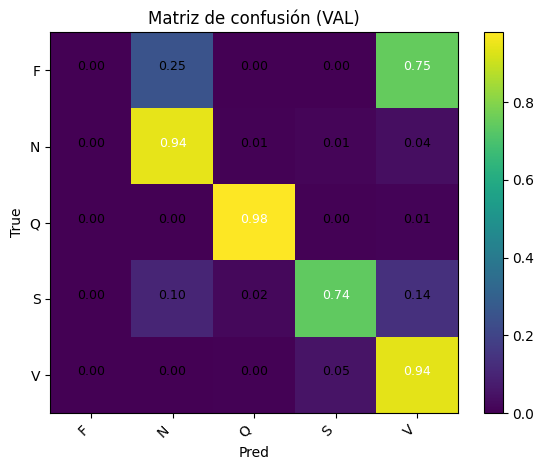

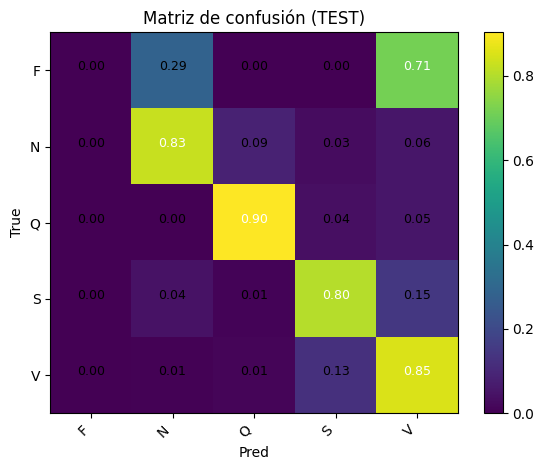

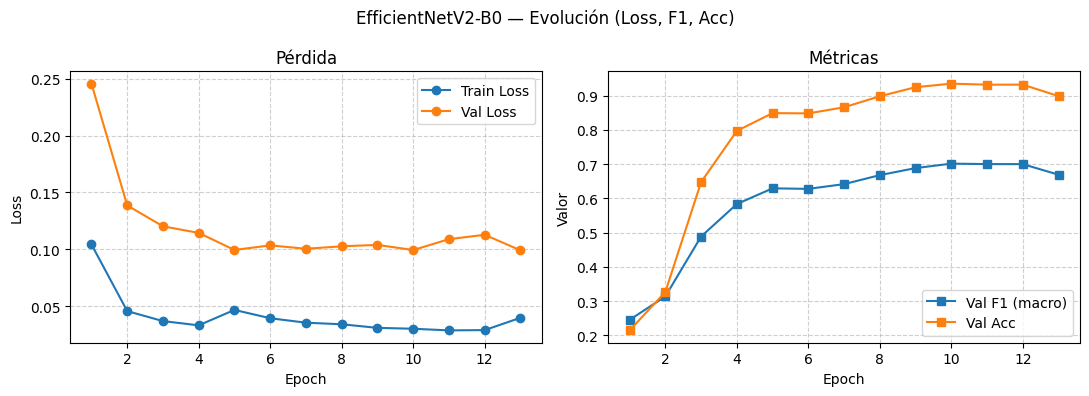

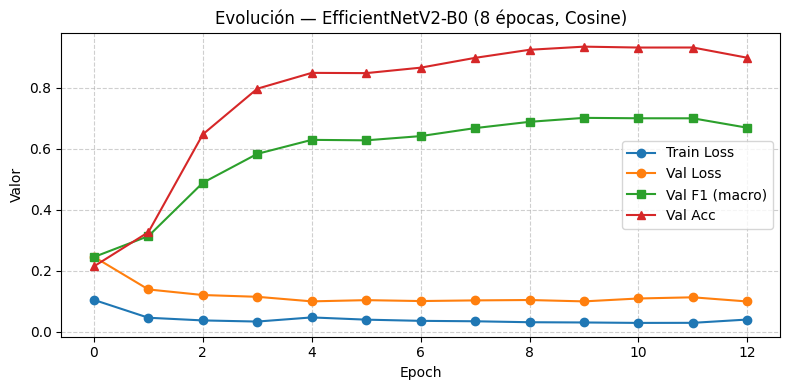


 Métricas finales (EfficientNetV2-B0):
  Último Train Loss: 0.0399
  Último Val Loss:   0.0992
  Último Val F1:     0.6689
  Último Val Acc:    0.8984


In [27]:
# ============================================================
# 5.4-C — EfficientNetV2-B0 (entrenamiento corto y estable, COSINE)
# ============================================================

import matplotlib.pyplot as plt
import torch, os

# Usa el alias que soporte tu build_model. Ejemplos comunes:
# "efficientnet_v2_b0", "efficientnet_v2_s", "efficientnet_b0" (timm/torchvision)
arch_choice = "efficientnet_v2_b0"

try:
    model_eff, hist_eff, val_report_eff, test_report_eff = train_model_pretty(
        arch=arch_choice,
        num_epochs=15,               # entrenamiento corto
        lr=3e-4,                    # EfficientNet suele ir bien con 3e-4 ~ 5e-4 (AdamW + Cosine)
        weight_decay=1e-4,
        max_grad_norm=1.0,
        use_onecycle=False,         # ← COSINE (no OneCycle)
        dl_train=dl_train,
        dl_val=dl_val,
        dl_test=dl_test,
        class_weights_tensor=class_weights,
        labels_sorted=labels_sorted,
        device=device,
        ckpt_dir="./checkpoints",
        eval_test_each_epoch=False,
        early_stopping_patience=3,  # corta si no mejora
        dropout_rate=0.20,          # la red ya tiene drop connect interno; 0.2 es seguro
    )

except KeyboardInterrupt:
    print("\n Entrenamiento interrumpido manualmente. Guardando checkpoint temporal...")
    os.makedirs("saved_models", exist_ok=True)
    ckpt_path = os.path.join("saved_models", f"{arch_choice}_interrupt.pt")
    torch.save(model_eff.state_dict(), ckpt_path)
    print(f"Checkpoint guardado en: {ckpt_path}")
    raise

# ---------- Curvas ----------
plot_training_curves(hist_eff, title="EfficientNetV2-B0 — Evolución (Loss, F1, Acc)")

# ---------- Vista rápida ----------
plt.figure(figsize=(8,4))
plt.plot(hist_eff["train_loss"], label="Train Loss", marker="o")
plt.plot(hist_eff["val_loss"],   label="Val Loss",   marker="o")
plt.plot(hist_eff["val_f1"],     label="Val F1 (macro)", marker="s")
plt.plot(hist_eff["val_acc"],    label="Val Acc", marker="^")
plt.xlabel("Epoch"); plt.ylabel("Valor"); plt.title("Evolución — EfficientNetV2-B0 (8 épocas, Cosine)")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()

# ---------- Resumen ----------
print("\n Métricas finales (EfficientNetV2-B0):")
print(f"  Último Train Loss: {hist_eff['train_loss'][-1]:.4f}")
print(f"  Último Val Loss:   {hist_eff['val_loss'][-1]:.4f}")
print(f"  Último Val F1:     {hist_eff['val_f1'][-1]:.4f}")
print(f"  Último Val Acc:    {hist_eff['val_acc'][-1]:.4f}")
